 This is the ensemble file listing all the analysis in the paper


In [1]:
from IPython import get_ipython
ipython = get_ipython()
ipython.run_line_magic('reset', '-sf')
from src import params
import pandas as pd
from src import Models
from pathlib import Path
from src.Evaluate import metric,print_model_fits,sl_eva
from src import Shap
from src import SuperLearner

# platform = "jupyter"
# params.confirm_cwd(platform)

model_params = params.model_params

LightGBM version: 3.3.5
XGBoost version: 1.7.4
NumPy version: 1.23.5


In [3]:
def select_value(row):
    columns = row.index.tolist()
    if ('death_year' not in columns) or (pd.isnull(row['death_year'])):
        
        if ('deathY' not in columns) or (pd.isnull(row['deathY'])) :
                
            if ('radyear' not in columns) or (pd.isnull(row['radyear']) ):
                if row['death']==1:
                    val = 'Error'
                else:
                    val=None
            else:
                val = row['radyear']
        else:
            val = row['deathY']
    else:
        val = row['death_year']
    
    return val

datasets = {'HRS':'death_year','SHARE':'deathY','ELSA':'radyear','COMB':'death_year'}


# Data Description

In [3]:
# combinde dataset 
for types in range(1,5):
    print(f'type={types}')
    comb,domain_lst = params.read_merged_data(type = types)
    print(f'for this combination, there are {len(domain_lst)} variables, datashape = {comb.shape}')

    domain_name = 'combine_all'
    model_params['domain_dict'][domain_name]=domain_lst
    print(f'there are {len(domain_lst)} vars and they are \n{domain_lst}')
    comb['death_year']=comb.apply(select_value, axis=1)
    print(f'death Year starts:{comb["death_year"].min()}, ends:{comb["death_year"].max()}')
    


type=1
for this combination, there are 16 variables, datashape = (41752, 89)
there are 16 vars and they are 
['everdivorced', 'Zfatherseduc', 'currsmokeYN', 'maleYN', 'everrent', 'vigactivityYN', 'everunemployed', 'Zeduccat', 'age', 'nevermarried', 'rocc', 'migrantYN', 'eversmokeYN', 'ZwealthT', 'sleepYN', 'Zmotherseduc']
death Year starts:2005.0, ends:2021.0
type=2
for this combination, there are 25 variables, datashape = (34199, 82)
there are 25 vars and they are 
['everdivorced', 'everrent', 'Zmotherseduc', 'nevermarried', 'fathersocc', 'sleepYN', 'Zperceivedconstraints', 'everunemployed', 'sumadultAE', 'rocc', 'modactivityYN', 'vigactivityYN', 'migrantYN', 'Zposaffect', 'eversmokeYN', 'ZwealthT', 'Zoptimism', 'Zfatherseduc', 'currsmokeYN', 'Zhopelessness', 'Zeduccat', 'age', 'Znegaffect', 'maleYN', 'Zpessimism']
death Year starts:2006.0, ends:2021.0
type=3
for this combination, there are 29 variables, datashape = (21128, 81)
there are 29 vars and they are 
['everdivorced', 'Zincome

In [4]:
df_data_description=pd.DataFrame(columns = ['Dataset','Age range','Female portion','Risk factor number','Sample size','Death prevalence','prediction window','var set'])
table_name_dict = {'HRS': 'HRS','SHARE':'SHARE','ELSA':'ELSA','COMB_1':'All','COMB_2':'HRS+SHARE','COMB_3':'HRS+ELSA','COMB_4':'SHARE + ELSA'}


for dataset in datasets.keys():
    if dataset != 'COMB':
        df = params.data_reader(dataset=dataset,source='us',bio=False)
        age_range = f'{round(df["age"].min())}-{round(df["age"].max())}'
        female_portion = round((df.loc[df['maleYN']==-1,'maleYN'].count())/len(df),3)
        var_in_dataset = list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))
        
        df_data_description.loc[len(df_data_description),]=[dataset,age_range,female_portion,len(var_in_dataset),len(df),round(df['death'].sum()/len(df),3),f'{int(df[datasets[dataset]].min())} - {int(df[datasets[dataset]].max())}',var_in_dataset]    
        del var_in_dataset

    else:
        for i in [1,2,3,4]:
            df,domain_lst = params.read_merged_data(type =i)
            df['death_year']=df.apply(select_value, axis=1)
            
            age_range = f'{round(df["age"].min())}-{round(df["age"].max())}'
            female_portion =  round((df.loc[df['maleYN']==-1,'maleYN'].count())/len(df),3)
            
            df_data_description.loc[len(df_data_description),]=[table_name_dict[f'{dataset}_{i}'],age_range,female_portion,len(domain_lst),len(df),round(df['death'].sum()/len(df),3),f'{int(df[datasets[dataset]].min())} - {int(df[datasets[dataset]].max())}',domain_lst]    


df_data_description = df_data_description.T.drop(index=['var set']).reset_index()
df_data_description.columns = df_data_description.loc[0,:]
df_data_description = df_data_description.loc[1:,:]        
            
            

df_data_description_first = df_data_description[['Dataset','HRS','SHARE','ELSA']]
df_data_description_sec = df_data_description[['Dataset','HRS+ELSA','HRS+SHARE','HRS+ELSA','SHARE + ELSA']]
df_data_description_all = df_data_description[['Dataset','All']]

## Table 1: Data prev
## Table 1: Data prev

In [23]:
print(df_data_description_first.style.to_latex(index=False, caption='Death Window and Prevalence of All Datasets', label='tab:data_pre'))
print()
print(df_data_description_sec.style.to_latex(index=False, caption='Death Window and Prevalence of All Datasets', label='tab:data_pre_comb'))
print()
print(df_data_description_all.style.to_latex(index=False, caption='Death Window and Prevalence of All Datasets', label='tab:data_pre_comb'))


\begin{table}
\centering
\caption{Death Window and Prevalence of All Datasets}
\label{tab:data_pre}
\begin{tabular}{llll}
\toprule
           Dataset &         HRS &       SHARE &        ELSA \\
\midrule
         Age range &      50-104 &       50-99 &       50-94 \\
    Female portion &       0.592 &       0.541 &       0.559 \\
Risk factor number &          61 &          25 &          29 \\
       Sample size &       13575 &       20624 &        7553 \\
  Death prevalence &         0.3 &       0.202 &       0.055 \\
 prediction window & 2008 - 2019 & 2006 - 2021 & 2005 - 2012 \\
\bottomrule
\end{tabular}
\end{table}


\begin{table}
\centering
\caption{Death Window and Prevalence of All Datasets}
\label{tab:data_pre_comb}
\begin{tabular}{lllll}
\toprule
           Dataset &    HRS+ELSA &   HRS+SHARE &    HRS+ELSA & SHARE + ELSA \\
\midrule
         Age range &      50-104 &      50-104 &      50-104 &        50-99 \\
    Female portion &        0.58 &       0.561 &        0.58 &      

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## Table S1

In [42]:
var_dict=model_params['var_dict']

In [43]:
df_data_description=pd.DataFrame(columns = ['Dataset','Risk Factors'])
table_name_dict = {'HRS': 'HRS','SHARE':'SHARE','ELSA':'ELSA','COMB_1':'HRS+SHARE+ELSA','COMB_2':'HRS+SHARE','COMB_3':'HRS+ELSA','COMB_4':'SHARE + ELSA'}


for dataset in datasets.keys():
    if dataset != 'COMB':
        df = params.data_reader(dataset=dataset,source='us',bio=False)
        var_in_dataset = list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))
        
        df_data_description.loc[len(df_data_description),]=[dataset,', '.join([var_dict[x] for x in var_in_dataset])]    
        del var_in_dataset

    else:
        for i in [1,2,3,4]:
            df,domain_lst = params.read_merged_data(type =i)
            df['death_year']=df.apply(select_value, axis=1)
            
            df_data_description.loc[len(df_data_description),]=[table_name_dict[f'{dataset}_{i}'],', '.join([var_dict[x] if x in var_dict.keys() else x for x in domain_lst])]
            

In [ ]:
with pd.option_context("max_colwidth", 100000):
    print(df_data_description.style.to_latex(index=False, caption='Death Window and Prevalence of All Datasets', label='tab:data_pre'))

### Table S2

In [63]:
df_data_description=pd.DataFrame(columns = ['Dataset','Risk Factors'])
table_name_dict = {'HRS': 'HRS','SHARE':'SHARE','ELSA':'ELSA','COMB_1':'HRS+SHARE+ELSA','COMB_2':'HRS+SHARE','COMB_3':'HRS+ELSA','COMB_4':'SHARE + ELSA'}
domain_var_dict = {}
basic_domains = ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']
replace_name_dict={'demographic':'Demography',
                       'child_adverse':'Child-Adversity',
                      'adult_SES':'Socioeconomic',
                      'behavioral':'Behaviours',
                      'adult_adverse':'Adversity',
                      'social_connection':'Connections',
                      'psych':'Psychological '}


for dataset in datasets.keys():
    
    
    if dataset != 'COMB':
        domain_var_dict[dataset]={}
        df = params.data_reader(dataset=dataset,source='us',bio=False)
        if dataset == 'SHARE':
            df = df.loc[(df['deathY']>2005)|( df['death']==0),]
        
        var_in_dataset = list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))
        
        for var in var_in_dataset:
            for domain in basic_domains:
                if (var in model_params['domain_dict'][domain] ) :
                    if domain not in domain_var_dict[dataset].keys():
                        domain_var_dict[dataset][domain]=[var]
                    else:
                        domain_var_dict[dataset][domain]+=[var]
        df_data_description.loc[len(df_data_description),]=[dataset,', '.join([var_dict[x] for x in var_in_dataset])]    
        del var_in_dataset

    else:
        for i in [1,2,3,4]:
            domain_var_dict[f'{dataset}_{i}']={}
            
            df,domain_lst = params.read_merged_data(type =i)
            df['death_year']=df.apply(select_value, axis=1)
            
            df_data_description.loc[len(df_data_description),]=[table_name_dict[f'{dataset}_{i}'],', '.join([var_dict[x] if x in var_dict.keys() else x for x in domain_lst])]
            
            for var in domain_lst:
                for domain in basic_domains:
                    if (var in model_params['domain_dict'][domain] ) :
                        if domain not in domain_var_dict[f'{dataset}_{i}'].keys():
                            domain_var_dict[f'{dataset}_{i}'][domain]=[var]
                        else:
                            domain_var_dict[f'{dataset}_{i}'][domain]+=[var]

In [ ]:
df_domain_var = pd.DataFrame(columns=['Dataset']+basic_domains)
for dataset in domain_var_dict.keys():
    #print(dataset)
    #for domain in basic_domains:
    #    print(f'    {domain},{len(domain_var_dict[dataset][domain])}')#,{domain_var_dict[dataset][domain]}
    df_domain_var.loc[len(df_domain_var),] = [dataset]+[len(domain_var_dict[dataset][domain]) for domain in basic_domains]
    

## Table S3: domain list of each dataset

In [44]:
basic_domains = ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']
replace_name_dict={'demographic':'Demography',
                       'child_adverse':'Child-Adversity',
                      'adult_SES':'Socioeconomic',
                      'behavioral':'Behaviours',
                      'adult_adverse':'Adversity',
                      'social_connection':'Connections',
                      'psych':'Psychological '}

df_domain_list = pd.DataFrame(columns=['Dataset','Domain','Variable Count','Variables'])

for domain_name in ['HRS','SHARE','ELSA']:
    df = params.data_reader(dataset=domain_name,source='us',bio=False)

    model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))

    domains = []
    domain_with_var={}
    for domain in basic_domains:
        domain_with_var[domain]=[]
        for var in model_params['domain_dict'][domain_name]:
            if domain!='demographic':
                if (var in model_params['domain_dict'][domain])& (var not in model_params['domain_dict']['demographic']) :
                    domain_with_var[domain].append(var)
            else:
                if (var in model_params['domain_dict'][domain]):
                    domain_with_var[domain].append(var)
    
    for key,val in domain_with_var.items():
        df_domain_list.loc[len(df_domain_list),]=[domain_name,replace_name_dict[key],len(val),', '.join([var_dict[x] for x in val])]


In [45]:
with pd.option_context("max_colwidth", 100000):
    print(df_domain_list.style.to_latex(index=False, caption='Risk Factors by Dataset and Domain', label='tab:data_var_list_by_domain'))

\begin{table}
\centering
\caption{Risk Factors by Dataset and Domain}
\label{tab:data_var_list_by_domain}
\begin{tabular}{llll}
\toprule
Dataset &          Domain & Variable Count &                                                                                                                                                                                                                                                                                                                                                                                              Variables \\
\midrule
    HRS &      Demography &              5 &                                                                                                                                                                                                                                                                                                                                                               Foreign Born, Hispan

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


# Model Prediction

note that the model performance is not the same as the one in the paper as here we only use one seed, in the paper, the results are averaged across 10 seeds (see codes in section 9.seed)

## HRS

In [1]:
from IPython import get_ipython
ipython = get_ipython()
ipython.run_line_magic('reset', '-sf')
from src import params
import pandas as pd
from src import Models
from pathlib import Path
from src.Evaluate import metric,print_model_fits,sl_eva
from src import Shap
from src import SuperLearner

# platform = "jupyter"
# params.confirm_cwd(platform)

model_params = params.model_params

LightGBM version: 3.3.5
XGBoost version: 1.7.4
NumPy version: 1.23.5


In [2]:
df = params.data_reader(dataset='HRS',source='us',bio=False)
for model_name in ['lgb','xgb']:
    print(f'model is {model_name}-----------------')
    model_params['domain_dict']['all'].sort()
    model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain='all', model=model_name, train_subset_size=1, order=0)
    print_model_fits(evas=metric(model))

model is lgb-----------------
imv=0.2455161338400571,
roc-auc=0.836143620043177,
pr-auc=0.7374697553141373,
f1=0.7861527129879695,
fb=0.5728034771809997,
efron_r2=0.32594810281828035,
ffc_r2=0.5954034293924696,
IP=0.30877709955798777
model is xgb-----------------
imv=0.24411581476727484,
roc-auc=0.8349584192272523,
pr-auc=0.7357908303437357,
f1=0.7780505769702921,
fb=0.5554691146724756,
efron_r2=0.3220311137529249,
ffc_r2=0.593052274608133,
IP=0.30877709955798777


## SHARE

In [3]:
df = params.data_reader(dataset='SHARE',source='us',bio=False)
domain_name = 'share_all'
# recode a new domain dict for SHARE  based on its columns
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))
model_params['domain_dict'][domain_name].sort()
# fit model
for model_name in ['lgb','xgb']:
    print(f'model is {model_name} -----------------')
    model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain=domain_name, model=model_name, train_subset_size=1, order=0)
    print_model_fits(evas=metric(model))

model is lgb -----------------
imv=0.07004717121858327,
roc-auc=0.7824837326323998,
pr-auc=0.5032241485971838,
f1=0.8175500969618618,
fb=0.3414676966292135,
efron_r2=0.18718042397217327,
ffc_r2=0.43212623424180463,
IP=0.2009559434746467
model is xgb -----------------
imv=0.0688620815251683,
roc-auc=0.779659741731676,
pr-auc=0.504989453046936,
f1=0.8183581124757594,
fb=0.3425259090110661,
efron_r2=0.18592313438015395,
ffc_r2=0.43124783293808877,
IP=0.2009559434746467


## ELSA

 there are 210 sample in ELSA that are below the age 50 

In [4]:
df = params.data_reader(dataset='ELSA',source='us',bio=False)
domain_name = 'elsa_all'
# recode a new domain dict for SHARE  based on its columns
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))
model_params['domain_dict'][domain_name].sort()
# fit model
for model_name in ['lgb','xgb']:
    print(f'model is {model_name} -----------------')
    model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain=domain_name, model=model_name, train_subset_size=1, order=0)
    print_model_fits(evas=metric(model))

model is lgb -----------------
imv=0.0579427489586478,
roc-auc=0.8274303859306302,
pr-auc=0.5001235521379114,
f1=0.8647360703812317,
fb=0.39466806063774185,
efron_r2=0.22578913381568644,
ffc_r2=0.43161832288098956,
IP=0.15758051846032992
model is xgb -----------------
imv=0.060117522287204045,
roc-auc=0.8310013820516995,
pr-auc=0.5021038410749534,
f1=0.8629032258064516,
fb=0.38259958071278827,
efron_r2=0.23098535057765657,
ffc_r2=0.435433090313018,
IP=0.15758051846032992


## Combined Prediction


In [5]:
df,domain_lst = params.read_merged_data(type=3)
domain_name = 'combine_all'
domain_lst.sort()
model_params['domain_dict'][domain_name]=domain_lst

for model_name in ['lgb','xgb']:
    print(f'model is {model_name} -----------------')
    model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain=domain_name, model=model_name, train_subset_size=1, order=0)
    print_model_fits(evas=metric(model))
    if model_name =='lgb':
        model_result = model

You are merging on int and float columns where the float values are not equal to their int representation.


model is lgb -----------------
imv=0.13525392289029461,
roc-auc=0.8296727131442535,
pr-auc=0.643819161000654,
f1=0.8097338626672548,
fb=0.48667512690355336,
efron_r2=0.2846894430110911,
ffc_r2=0.5637796520040278,
IP=0.2541123085649461
model is xgb -----------------
imv=0.1359497360818329,
roc-auc=0.8302063077896462,
pr-auc=0.6462883282432643,
f1=0.8095868254668431,
fb=0.4794346109766968,
efron_r2=0.28497108439298646,
ffc_r2=0.5639514063566233,
IP=0.2541123085649461


# Survival Model 

 find them in a separate file

# SHAP


In [1]:
from IPython import get_ipython
ipython = get_ipython()
ipython.run_line_magic('reset', '-sf')
from src import params
import pandas as pd
from src import Models
from src import Shap

LightGBM version: 3.3.5
XGBoost version: 1.7.4
NumPy version: 1.23.5


In [3]:
df_shaps = pd.DataFrame(columns=['var'])
model_params=params.model_params
colors = {
    'light_blue': '#a3d5e4',  # Existing light blue
    'blue': '#41678d',        # Existing blue
    'purple': '#7b6785',      # Existing purple
    'red': '#d18375',         # Existing red
    'peach': '#efb68d',       # Existing peach
    'teal': '#6aa2a3',        # New teal color
    'soft_pink': '#d19cbb',   # New soft pink color
    'warm_yellow': '#f2c46d'  # New warm yellow color
}

## HRS


In [4]:
# fit model
dataset= 'HRS'
df = params.data_reader(dataset='HRS',source='us',bio=False)
model_params['domain_dict']['all'].sort()
model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain='all', model='lgb',
                                     train_subset_size=1, order=0)
# print_model_fits(evas=metric(model))
# calcualte shap

shap_values_test,shap_dict = Shap.shap_values_and_dict(model)
temp = pd.DataFrame([x for x in Shap.shap_absolute_rank(shap_values_test) if x[1]>=0.1], columns=['var',dataset])
df_shaps =pd.merge(left= df_shaps, right = temp, left_on='var',right_on='var',how='outer')


In [5]:
# all predicted shap values 
df_shap_all_HRS = Shap.shap_values_and_dict_all(model)

shap rank bar plot

Shap.shap_rank_bar_plot(shap_values_test=shap_values_test,
                   var_dict=model_params['var_dict'],
                   max_display=shap_values_test.shape[1])

## SHARE  

In [6]:
df = params.data_reader(dataset='SHARE',source='us',bio=False)
domain_name = 'share_all'
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))
model_params['domain_dict'][domain_name].sort()
model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain=domain_name, model='lgb',
                                     train_subset_size=1, order=0)
shap_values_test,shap_dict = Shap.shap_values_and_dict(model)

dataset = 'SHARE'
temp = pd.DataFrame([x for x in Shap.shap_absolute_rank(shap_values_test) if x[1]>=0.1],
                    columns=['var',dataset])
df_shaps =pd.merge(left= df_shaps, right = temp, left_on='var',right_on='var',how='outer')


In [7]:
df_shap_all_SHARE = Shap.shap_values_and_dict_all(model)

## ELSA

In [8]:
df = params.data_reader(dataset='ELSA',source='us',bio=False)
domain_name = 'elsa_all'
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))
model_params['domain_dict'][domain_name].sort()
model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain=domain_name, model='lgb',train_subset_size=1, order=0)
shap_values_test,shap_dict = Shap.shap_values_and_dict(model)

dataset = f'ELSA'
temp = pd.DataFrame([x for x in Shap.shap_absolute_rank(shap_values_test) if x[1]>=0.1], columns=['var',dataset])
df_shaps =pd.merge(left= df_shaps, right = temp, left_on='var',right_on='var',how='outer')

In [9]:
df_shap_all_ELSA = Shap.shap_values_and_dict_all(model)

Shap.shap_rank_bar_plot(shap_values_test=shap_values_test,
                   var_dict=model_params['var_dict'],
                   max_display=shap_values_test.shape[1])

Shap.top_10_scatter_plot(shap_values_test=shap_values_test,var_dict=model_params['var_dict'])

df = params.data_reader(dataset='ELSA',source='us',bio=False)
domain_name = 'elsa_all'
df = df.loc[df['age']>=50,]
df['ZwealthT'].hist(bins=100)

## Combination 

In [10]:
comb_type = 3

df,model_params['domain_dict'][domain_name] = params.read_merged_data(type=comb_type)
model_params['domain_dict'][domain_name].sort()

model_params['var_dict']['dataset']='Datasource'
model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain=domain_name, model='lgb', train_subset_size=1, order=0)
shap_values_test,shap_dict = Shap.shap_values_and_dict(model)

dataset = f'COMB_{comb_type}'
temp = pd.DataFrame([x for x in Shap.shap_absolute_rank(shap_values_test) if x[1]>=0.1],
                    columns=['var',dataset])
df_shaps =pd.merge(left= df_shaps, right = temp, left_on='var',right_on='var',how='outer')

You are merging on int and float columns where the float values are not equal to their int representation.


In [11]:
df_shap_all_COMB = Shap.shap_values_and_dict_all(model)

In [12]:
# ELSA in COMB 
shap_values_test,shap_dict = Shap.shap_values_and_dict(model)
ELSA_ind = df.loc[df['dataset']==2].index

# retreive the ELSA index in the shap values 
temp_test = pd.concat([model.X_train,model.X_test]).copy()
temp_test.reset_index(inplace=True)

ELSA_in_X_test = temp_test.loc[(temp_test['index'].isin(ELSA_ind)),].index

df_shap_values_comb=pd.DataFrame(columns=list(model.X_test.columns),data=shap_values_test.values)
df_shap_all_COMB_ELSA= df_shap_values_comb.loc[ELSA_in_X_test,]
shap_dict_ELSA_sub_component ={col:df_shap_all_COMB_ELSA[col].abs().mean() for col in df_shap_all_COMB_ELSA.columns}


# concating the original values of the test set into df_shap_all_COMB_ELSA
df_shap_all_COMB_ELSA.rename(columns={x:f"{x}_shap" for x in df_shap_all_COMB_ELSA.columns},inplace=True)
temp = pd.DataFrame(columns=list(model.X_test.columns),data=shap_values_test.data)
temp= temp.loc[ELSA_in_X_test,]
df_shap_all_COMB_ELSA=pd.concat([temp,df_shap_all_COMB_ELSA],axis=1)



dataset = f'ELSA_in_COMB_{comb_type}'
temp = pd.DataFrame(shap_dict_ELSA_sub_component,index=[dataset]).T

temp=temp.reset_index().rename(columns={'index':'var'})
temp= temp.loc[temp[dataset]>0.1,]


df_shaps =pd.merge(left= df_shaps, right = temp, left_on='var',right_on='var',how='outer')
df_shaps

,var,HRS,SHARE,ELSA,COMB_3,ELSA_in_COMB_3
0,age,0.971168,0.930972,1.093226,1.066822,1.086637
1,maleYN,0.256927,0.188921,0.271892,0.243221,0.247142
2,modactivityYN,0.167910,NaN,NaN,NaN,NaN
3,eversmokeYN,0.153183,NaN,0.131761,0.117882,NaN
4,ZincomeT,0.149482,NaN,0.329579,NaN,NaN
5,ZwealthT,0.124615,0.120840,NaN,NaN,NaN
6,Zanxiety,0.123453,NaN,NaN,NaN,NaN
7,vigactivityYN,0.121151,NaN,0.224005,0.252059,0.253448
8,currsmokeYN,NaN,0.223588,0.131481,0.112511,0.120440
9,Zeduccat,NaN,0.109384,0.100638,0.123571,0.118319


## Figure 1: SHAP overall rank

df_shaps.drop(df_shaps[df_shaps['var']=='dataset'].index,inplace=True)

shap_overall_rank_plot(df_shaps=df_shaps,save_control=False,var_dict=model_params['var_dict'])

FixedFormatter should only be used together with FixedLocator


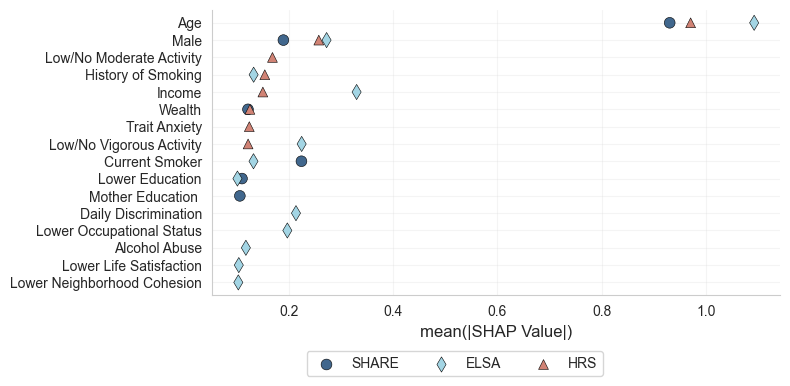

In [16]:
import matplotlib.pyplot as plt
from pathlib import Path 

fontsize_ticks = 12
fontsize_labels = 12
linewidth=0.4
var_dict = model_params['var_dict']
df_shap_plot= df_shaps[['var','HRS',f'ELSA','SHARE']].copy()
df_shap_plot.dropna(thresh=2,inplace=True)
df_shap_plot.sort_values(by=['HRS'],ascending=[False],inplace=True)

fig,ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(8)
ax.scatter(df_shap_plot['SHARE'], df_shap_plot['var'], label='SHARE',color=colors['blue'],marker='o',s=[60]*len(df_shap_plot['var']),edgecolors='black',linewidth=linewidth)
ax.scatter(df_shap_plot[f'ELSA'], df_shap_plot['var'], label='ELSA',color=colors['light_blue'],marker='d',s=[60]*len(df_shap_plot['var']),edgecolors='black',linewidth=linewidth)
ax.scatter(df_shap_plot['HRS'], df_shap_plot['var'], label='HRS',color=colors['red'],marker='^',s=[50]*len(df_shap_plot['var']),edgecolors='black',linewidth=linewidth)

    
ax.grid(axis='both',alpha=0.2)
ylabels = [var_dict[y_tick.get_text()] for y_tick in ax.get_yticklabels()]
ax.set_yticklabels(ylabels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('mean(|SHAP Value|)', fontsize=fontsize_labels)

ax.legend(bbox_to_anchor=(0.7, -0.17),ncol=3)
plt.gca().invert_yaxis()
fig.tight_layout()
del df_shap_plot
plt.savefig(Path.cwd() / f'graphs/model_outputs/shap_overall_ranks_all.pdf')


## SHAP Ranks by age groups 

now we have four df including df_shap_all_COMB, df_shap_all_SHARE,df_shap_all_HRS and df_shap_all_ELSA that store the information of original data + the corresponding shaps, both on train and test dataset

In [17]:
# Define bins and labels
bins = [50, 54, 59, 64, 69, 74, 79, 84, 89, float('inf')]
labels = ['50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90+']

# Function to categorize age
def categorize_age(df):
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)
    return df

# Apply function to each dataframe
df_shap_all_COMB = categorize_age(df_shap_all_COMB)
df_shap_all_SHARE = categorize_age(df_shap_all_SHARE)
df_shap_all_HRS = categorize_age(df_shap_all_HRS)
df_shap_all_ELSA = categorize_age(df_shap_all_ELSA)
df_shap_all_COMB_ELSA = categorize_age(df_shap_all_COMB_ELSA)

plot HRS,SHARE and COMB into the same plot 

first rows: common factors 
second rows of plot: by different datasets (their own risk factors) 

common risk factors 

In [41]:
# absolute levels
import numpy as np 
shap_cols = [x for x in df_shap_all_HRS.columns if 'shap' in x]
for col in shap_cols:
    df_shap_all_HRS[col]=np.abs(df_shap_all_HRS[col])

shap_cols = [x for x in df_shap_all_SHARE.columns if 'shap' in x]
for col in shap_cols:
    df_shap_all_SHARE[col]=np.abs(df_shap_all_SHARE[col])
    
shap_cols = [x for x in df_shap_all_ELSA.columns if 'shap' in x]
for col in shap_cols:
    df_shap_all_ELSA[col]=np.abs(df_shap_all_ELSA[col])
    
    
    
# merge the data into temp
temp_HRS = df_shap_all_HRS.groupby('age_group').mean(numeric_only=True)
temp_HRS.columns = [x+'_HRS' if x!='age_group' else x for x in temp_HRS.columns]

temp_SHARE = df_shap_all_SHARE.groupby('age_group').mean(numeric_only=True)
temp_SHARE.columns = [x+'_SHARE' if x!='age_group' else x for x in temp_SHARE.columns]

temp = pd.merge(left=temp_HRS,left_on='age_group',right=temp_SHARE,right_on='age_group')

temp_ELSA = df_shap_all_ELSA.groupby('age_group').mean(numeric_only=True)
temp_ELSA.columns = [x+'_ELSA' if x!='age_group' else x for x in temp_ELSA.columns]

temp = pd.merge(left=temp,left_on='age_group',right=temp_ELSA,right_on='age_group')


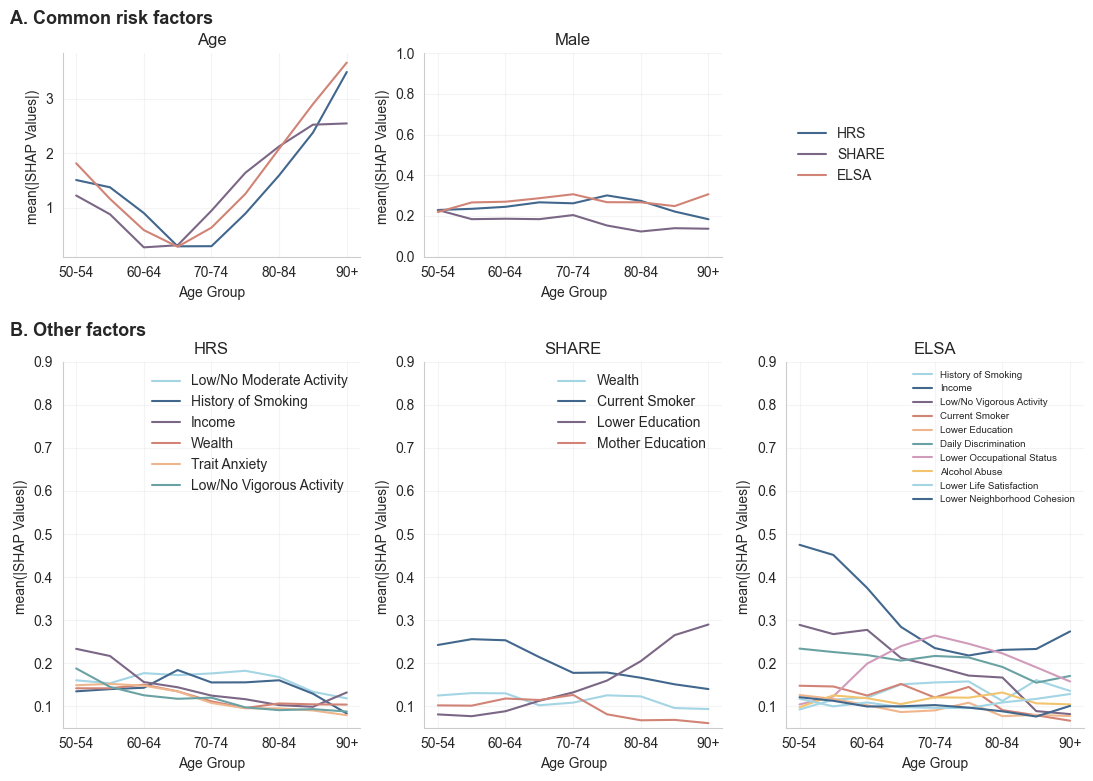

In [43]:
# vars in common = ['age','maleYN','ZwealthT']

from matplotlib import pyplot as plt 
cols_all = ['age_shap','maleYN_shap']
datasets = ['HRS','SHARE','ELSA']
fig,axs = plt.subplots(2,3,figsize=(11, 8),gridspec_kw={'height_ratios': [1, 1.8]})
var_dict = model_params['var_dict']


for j in range(0, 2):
    for i in range(0, 3):
        if j == 0:
            if i==2:
                continue
            col = cols_all[i]
            cols = [f'{col}_{y}' for y in datasets]
            
            if i == 0 and j == 0:
                temp.plot(y=cols, ax=axs[j, i], title=var_dict[col.replace("_shap", '')],color=list(colors.values())[1:4]).legend(loc='best')
                axs[j, i].legend(['HRS', 'SHARE', 'ELSA'],frameon=False)
            else:
                temp.plot(y=cols, ax=axs[j, i], title=var_dict[col.replace("_shap", '')],color=list(colors.values())[1:4], legend=False)
            
        else:
            dataset = datasets[i]
            
            y_cols = [f'{x}_shap_{dataset}' for x in df_shaps.loc[df_shaps[dataset].notnull(), 'var']]
            for col in cols_all:
                y_cols.remove(f'{col}_{dataset}')
            if dataset == "ELSA":
                temp.plot(y=y_cols, ax=axs[j, i], title='ELSA',color=list(colors.values())).legend(loc='best')
                handles, labels = axs[j, i].get_legend_handles_labels()
                axs[j, i].legend([var_dict[x.split("_")[0]] for x in labels],frameon=False,fontsize=7)
            else:
                temp.plot(y=y_cols, ax=axs[j, i], title=dataset,color=list(colors.values())).legend(loc='best')
                handles, labels = axs[j, i].get_legend_handles_labels()
                axs[j, i].legend([var_dict[x.split("_")[0]] for x in labels],frameon=False)
        
        axs[j, i].grid(axis='both',alpha=0.2)
        axs[j, i].set_ylabel('mean(|SHAP Values|) ')
        axs[j, i].set_xlabel('Age Group')
        #axs[j, i].axhline(0, color='grey', ls='--')
        axs[j, i].spines['top'].set_visible(False)
        axs[j, i].spines['right'].set_visible(False)
        
axs[0,1].set_ylim(0.0,1.0)
axs[0,2].visible=False

axs[1,0].set_ylim(0.05,0.9)
axs[1,1].set_ylim(0.05,0.9)
axs[1,2].set_ylim(0.05,0.9)

axs[0,2].clear()
axs[0,2].axis('off')  # Turn off the axis completely

# Move the legend from axs[0,1] to axs[0,2]
handles, labels = axs[0,0].get_legend_handles_labels()
axs[0,2].legend(handles, ['HRS', 'SHARE', 'ELSA'], frameon=False, loc='center left', fontsize=10)

axs[0,0].legend_.remove()
# Redraw the figure with adjustments
fig.text(0.01, 0.97, "A. Common risk factors", ha='left', va='top', fontsize=13, weight="bold")
fig.text(0.01, 0.58, "B. Other factors", ha='left', va='top', fontsize=13, weight="bold")

# Adjust layout to ensure proper spacing
fig.tight_layout(rect=[0, 0, 1, 0.96], h_pad=3.0)

# Save the modified figure
plt.savefig(Path.cwd() / 'graphs/model_outputs/shap_by_age_group_all.pdf')

# SuperLearner 

In [1]:
from src import params
import pandas as pd
from src import Models
from pathlib import Path
from src.Evaluate import metric,print_model_fits,sl_eva
from src import Shap
from src import SuperLearner
import random 
import warnings
warnings.filterwarnings('ignore')
#platform = "jupyter"
#params.confirm_cwd(platform)
model_params = params.model_params

# specification
model_params['k'] = 10
model_params['y_colname'] = 'death'

LightGBM version: 3.3.5
XGBoost version: 1.7.4
NumPy version: 1.23.5


## HRS

In [2]:
df = params.data_reader(dataset='HRS',source='us',bio=False)
domain = 'all'

df_eva_10_seeds = pd.DataFrame()

for i in range(0,10):
    seed = random.randint(a=1,b=2**32 - 1)
    model_params['seed']=seed 
    print(seed)
    domain_lst = model_params['domain_dict'][domain]
    domain_lst.sort()
    superlearner = SuperLearner.superlearner(data=df,
                            test_size=model_params['test_size'],
                            domain_list=domain_lst,
                            y_colname=model_params['y_colname'],
                            k=model_params['k'],
                            random_state=seed,
                            train_subset_size=1)
    df_eva=sl_eva(superlearner)
    df_eva['seed']=[seed]*len(df_eva)
    df_eva_10_seeds=pd.concat([df_eva,df_eva_10_seeds],axis=0)
df_eva_10_seeds  

3267513483
9502 9502
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
984794136
9502 9502
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
3316367278
9502 9502
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
2309658613
9502 9502
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
3829690777
9502 9502
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
1830054538
9502 9502
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
2507563457
9502 9502
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
901450009
9502 9502
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
4221110662
9502 9502
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
957810778
9502 9502
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


,model,pr_auc,roc_auc,f1,fb,efron,ffc,ip,imv,seed
0,XGB,0.661986,0.792786,0.753990,0.537328,0.203421,0.548366,0.313829,0.125565,957810778
1,LGB,0.695163,0.812051,0.769703,0.547836,0.275177,0.589049,0.313829,0.199883,957810778
2,SGD,0.686866,0.800922,0.761355,0.449775,-0.073004,0.391642,0.313829,-0.260757,957810778
3,DecisionTree,0.590869,0.639280,0.683526,0.513345,-0.446446,0.179913,0.313829,-0.260757,957810778
4,AdaBoost,0.699453,0.817221,0.771422,0.559618,-0.114858,0.367912,0.313829,-0.145734,957810778
...,...,...,...,...,...,...,...,...,...,...
8,KNeighbors,0.618162,0.739231,0.742696,0.495620,0.129574,0.517817,0.315828,-0.266099,3267513483
9,Bagging,0.620609,0.760028,0.748834,0.476543,0.171220,0.540887,0.315828,-0.266099,3267513483
10,RandomForest,0.603868,0.751877,0.742205,0.428954,0.174409,0.542654,0.315828,-0.266099,3267513483
11,ExtraTrees,0.584059,0.737818,0.730665,0.393382,0.152675,0.530614,0.315828,-0.266099,3267513483


In [3]:
df_eva_10_seeds.to_csv(Path.cwd()/'results/sl_10seeds_HRS.csv',index=False)

## SHARE

In [4]:
df = params.data_reader(dataset='SHARE',source='us',bio=False)

domain_name = 'share'
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))
model_params['domain_dict'][domain_name].sort()

df_eva_10_seeds = pd.DataFrame()

for i in range(0,10):
    seed = random.randint(a=1,b=2**32 - 1)
    model_params['seed']=seed 
    superlearner = SuperLearner.superlearner(data=df,
                            test_size=model_params['test_size'],
                            domain_list=model_params['domain_dict'][domain_name],
                            y_colname=model_params['y_colname'],
                            k=model_params['k'],
                            random_state=seed,
                            train_subset_size=1)
    df_eva=sl_eva(superlearner)
    df_eva['seed']=[seed]*len(df_eva)
    df_eva_10_seeds=pd.concat([df_eva,df_eva_10_seeds],axis=0)
  

14436 14436
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
14436 14436
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
14436 14436
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
14436 14436
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
14436 14436
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
14436 14436
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
14436 14436
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
14436 14436
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
14436 14436
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
14436 14436
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


In [5]:
df_eva_10_seeds.to_csv(Path.cwd()/'results/sl_10seeds_SHARE.csv',index=False)

## ELSA

In [6]:
df = params.data_reader(dataset='ELSA',source='us',bio=False)

domain = 'ELSA'
model_params['domain_dict'][domain]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))
model_params['domain_dict'][domain].sort()
df_eva_10_seeds = pd.DataFrame()

for i in range(0,10):
    seed = random.randint(a=1,b=2**32 - 1)
    model_params['seed']=seed 
    superlearner = SuperLearner.superlearner(data=df,
                            test_size=model_params['test_size'],
                            domain_list=model_params['domain_dict'][domain],
                            y_colname=model_params['y_colname'],
                            k=model_params['k'],
                            random_state=seed,
                            train_subset_size=1)
    df_eva=sl_eva(superlearner)
    df_eva['seed']=[seed]*len(df_eva)
    df_eva_10_seeds=pd.concat([df_eva,df_eva_10_seeds],axis=0)
df_eva_10_seeds  

6365 6365
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
6365 6365
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
6365 6365
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
6365 6365
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
6365 6365
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
6365 6365
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
6365 6365
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
6365 6365
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
6365 6365
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
6365 6365
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


,model,pr_auc,roc_auc,f1,fb,efron,ffc,ip,imv,seed
0,XGB,0.467749,0.815020,0.849340,0.310416,0.165747,0.362345,0.154753,0.037119,4265120468
1,LGB,0.498292,0.825489,0.857405,0.331961,0.219401,0.403355,0.154753,0.058795,4265120468
2,SGD,0.561788,0.821958,0.765762,0.622817,-0.730349,-0.322579,0.154753,-0.405902,4265120468
3,DecisionTree,0.402195,0.615225,0.788856,0.357143,-0.584204,-0.210874,0.154753,-0.405902,4265120468
4,AdaBoost,0.508133,0.830873,0.856305,0.340328,-0.776497,-0.357851,0.154753,-0.269286,4265120468
...,...,...,...,...,...,...,...,...,...,...
8,KNeighbors,0.435529,0.754027,0.843109,0.331778,0.098184,0.336395,0.157423,-0.410246,232144218
9,Bagging,0.435132,0.775640,0.855205,0.344374,0.128024,0.358353,0.157423,-0.410246,232144218
10,RandomForest,0.449046,0.785467,0.862537,0.284464,0.162753,0.383909,0.157423,-0.410246,232144218
11,ExtraTrees,0.451917,0.790446,0.853739,0.241758,0.169915,0.389179,0.157423,-0.410246,232144218


In [7]:
df_eva_10_seeds.to_csv(Path.cwd()/'results/sl_10seeds_ELSA.csv',index=False)

## Combed data 

In [8]:
for comb_type in [1,2,3,4]:
    domain_name = 'combination_all'
    df,domain_lst = params.read_merged_data(type=comb_type)
    model_params['domain_dict'][domain_name]=domain_lst

    df,model_params['domain_dict'][domain_name]= params.read_merged_data(type=comb_type)
    model_params['domain_dict'][domain_name].sort()
    #model_params['domain_dict'][domain_name].remove('hhid')
    #model_params['domain_dict'][domain_name].remove('pn')
    model_params['var_dict']['dataset']='Datasource'

    df_eva_10_seeds = pd.DataFrame()

    for i in range(0, 10):
        print(i)
        seed = random.randint(a=1,b=2**32 - 1)
        model_params['seed']=seed 
        superlearner = SuperLearner.superlearner(data=df,
                                test_size=model_params['test_size'],
                                domain_list=model_params['domain_dict'][domain_name],
                                y_colname=model_params['y_colname'],
                                k=model_params['k'],
                                random_state=seed,
                                train_subset_size=1)
        df_eva=sl_eva(superlearner)
        df_eva['seed']=[seed]*len(df_eva)
        df_eva_10_seeds=pd.concat([df_eva,df_eva_10_seeds],axis=0)
    df_eva_10_seeds.to_csv(Path.cwd()/f'results/sl_10seeds_COMB_{comb_type}.csv',index=False)
    df_eva_10_seeds  

0
30304 30304
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
1
30304 30304
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
2
30304 30304
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
3
30304 30304
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
4
30304 30304
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
5
30304 30304
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
6
30304 30304
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
7
30304 30304
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
8
30304 30304
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
9
30304 30304
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
0
23939 23939
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
1
23939 23939
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fo

## Table 2
## Table 2

In [9]:
import warnings 
warnings.simplefilter("ignore") 
table_name_dict = {'HRS': 'HRS','SHARE':'SHARE','ELSA':'ELSA','COMB_1':'All Three Datasets','COMB_2':'HRS + SHARE','COMB_3':'HRS + ELSA','COMB_4':'SHARE + ELSA'}


In [10]:
df_table_1 = pd.DataFrame()
for dataset in ['HRS','SHARE','ELSA','COMB_1','COMB_2','COMB_3','COMB_4']:
    df_eva_10_seeds = pd.read_csv(Path.cwd()/f'results/sl_10seeds_{dataset}.csv')
    for model in ['sl','LGB','LogisticRegression']:
        temp = pd.DataFrame(df_eva_10_seeds.loc[df_eva_10_seeds['model']==model].mean()).T
        temp.loc[len(temp)-1,['model','dataset']]=[model,dataset]
        df_table_1=pd.concat([df_table_1,temp],axis=0)

In [11]:
# table 2, latex format 
for datasets in [['HRS','SHARE','ELSA'],['COMB_2','COMB_3','COMB_4'],['COMB_1']]: 
    if len(datasets)!=1:
        print(table_name_dict[datasets[0]],table_name_dict[datasets[1]],table_name_dict[datasets[2]])
    
        for eva in ['imv','roc_auc','pr_auc','efron','ffc','ip']:

            print()
            print("{}   & {:.3f} &  {:.3f} &  {:.3f} & {:.3f} &  {:.3f} &  {:.3f} & {:.3f} &  {:.3f}&  {:.3f} \\\\".format(eva.upper().replace('_',' '),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[0])&(df_table_1['model']=='sl'),eva].values[0],3),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[0])&(df_table_1['model']=='LGB'),eva].values[0],3),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[0])&(df_table_1['model']=='LogisticRegression'),eva].values[0],3),

                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[1])&(df_table_1['model']=='sl'),eva].values[0],3),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[1])&(df_table_1['model']=='LGB'),eva].values[0],3),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[1])&(df_table_1['model']=='LogisticRegression'),eva].values[0],3),

                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[2])&(df_table_1['model']=='sl'),eva].values[0],3),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[2])&(df_table_1['model']=='LGB'),eva].values[0],3),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[2])&(df_table_1['model']=='LogisticRegression'),eva].values[0],3)))

            print()
    else:
        print(table_name_dict[datasets[0]])
        for eva in ['imv','roc_auc','pr_auc','efron','ffc','ip']:
            print("{}   & \multicolumn{{3}}{{c}}{{{:.3f}}} &  \multicolumn{{3}}{{c}}{{{:.3f}}} & \multicolumn{{3}}{{c}}{{{:.3f}}} \\\\".format(eva.upper().replace('_',' '),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[0])&(df_table_1['model']=='sl'),eva].values[0],3),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[0])&(df_table_1['model']=='LGB'),eva].values[0],3),
                                                                               round(df_table_1.loc[(df_table_1['dataset']==datasets[0])&(df_table_1['model']=='LogisticRegression'),eva].values[0],3)))
            print()       

HRS SHARE ELSA

IMV   & 0.192 &  0.195 &  0.111 & 0.073 &  0.077 &  -0.055 & 0.056 &  0.060&  0.068 \\


ROC AUC   & 0.814 &  0.816 &  0.823 & 0.789 &  0.795 &  0.453 & 0.823 &  0.828&  0.837 \\


PR AUC   & 0.687 &  0.691 &  0.702 & 0.508 &  0.522 &  0.172 & 0.491 &  0.499&  0.521 \\


EFRON   & 0.275 &  0.280 &  0.295 & 0.195 &  0.207 &  -0.041 & 0.208 &  0.221&  0.243 \\


FFC   & 0.602 &  0.605 &  0.613 & 0.443 &  0.451 &  0.279 & 0.394 &  0.404&  0.421 \\


IP   & 0.317 &  0.317 &  0.317 & 0.202 &  0.202 &  0.202 & 0.155 &  0.155&  0.155 \\

HRS + SHARE HRS + ELSA SHARE + ELSA

IMV   & 0.118 &  0.120 &  0.121 & 0.128 &  0.132 &  0.131 & 0.068 &  0.071&  0.072 \\


ROC AUC   & 0.809 &  0.811 &  0.813 & 0.822 &  0.825 &  0.823 & 0.798 &  0.803&  0.804 \\


PR AUC   & 0.609 &  0.612 &  0.611 & 0.631 &  0.636 &  0.632 & 0.497 &  0.513&  0.508 \\


EFRON   & 0.250 &  0.254 &  0.257 & 0.270 &  0.276 &  0.273 & 0.201 &  0.212&  0.211 \\


FFC   & 0.530 &  0.532 &  0.534 & 0.552 &  0.556 

## Combination

In [2]:
domain_name = 'combination_all'
df,model_params['domain_dict'][domain_name] = params.read_merged_data(type=1)
model_params['var_dict']['dataset']='Datasource'

In [ ]:

df_eva_10_seeds = pd.DataFrame()
for i in range(1,9):
    seed = random.randint(a=1,b=1000000000000)
    model_params['seed']=seed 
    superlearner = SuperLearner.superlearner(data=df,
                            test_size=model_params['test_size'],
                            domain_list=model_params['domain_dict']['combination_all'],
                            y_colname=model_params['y_colname'],
                            k=model_params['k'],
                            random_state=model_params['random_state'],
                            train_subset_size=1)
    df_eva=sl_eva(superlearner)
    df_eva['seed']=[seed]*len(df_eva)
    df_eva_10_seeds=pd.concat([df_eva,df_eva_10_seeds],axis=0)
    

In [13]:
df_eva_10_seeds

,model,pr_auc,roc_auc,f1,efron,ffc,ip,imv,seed
0,XGB,0.674514,0.863575,0.572674,0.342862,0.562336,0.224643,0.139033,581958458618
1,LGB,0.630034,0.840904,0.522448,0.292666,0.528905,0.224643,0.122198,581958458618
2,SGD,0.532138,0.768993,0.527175,-0.171521,0.219749,0.224643,-0.352873,581958458618
3,DecisionTree,0.739439,0.812944,0.707196,0.230866,0.487745,0.224643,-0.352873,581958458618
4,AdaBoost,0.581372,0.816307,0.480286,-0.381784,0.079710,0.224643,-0.242582,581958458618
...,...,...,...,...,...,...,...,...,...
8,KNeighbors,0.594081,0.812407,0.523251,0.226532,0.484858,0.224643,-0.352873,206243973551
9,Bagging,0.810744,0.913088,0.715294,0.502274,0.668506,0.224643,-0.352873,206243973551
10,RandomForest,0.800814,0.910525,0.699271,0.487248,0.658499,0.224643,-0.352873,206243973551
11,ExtraTrees,0.845327,0.923936,0.739791,0.548662,0.699401,0.224643,-0.352873,206243973551


In [12]:
df_eva_10_seeds.to_csv(Path.cwd()/'results/sl_10seeds.csv',index=False)

In [15]:
for seed in df_eva_10_seeds['seed'].unique():
    df_eva_10_seeds.loc[(df_eva_10_seeds['seed']==seed)]

# Domain Contribution

In [1]:
from IPython import get_ipython
ipython = get_ipython()
ipython.run_line_magic('reset', '-sf')
from src import params
import pandas as pd
from src import Models
from src.Domains_Diff_in_combination import get_dc_params,dc_iteration,dd_post_process,dc_plot
model_params = params.model_params

LightGBM version: 3.3.5
XGBoost version: 1.7.4
NumPy version: 1.23.5


## HRS

In [3]:
df = params.data_reader(dataset='HRS',source='us',bio=False)
domain_name = 'HRS'
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))

basic_domains = ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']

domains = []
for var in model_params['domain_dict'][domain_name]:
    for domain in basic_domains:
        if (var in model_params['domain_dict'][domain] )& (var not in model_params['domain_dict']['demographic']) :
            domains+=[domain]
domains = list(set(domains))+['demographic']

domain_name_lst,df_eval,iterations = get_dc_params(domains)

pr_f1_contribution
pr_auc_contribution
roc_auc_contribution
imv_contribution


/Users/valler/Python/OX_Thesis/OX_thesis/src/Domains_Diff_in_combination.py:231: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[m, n].set_yticklabels([replace_name_dict[x_tick] for x_tick in contribution['goal_domain']])


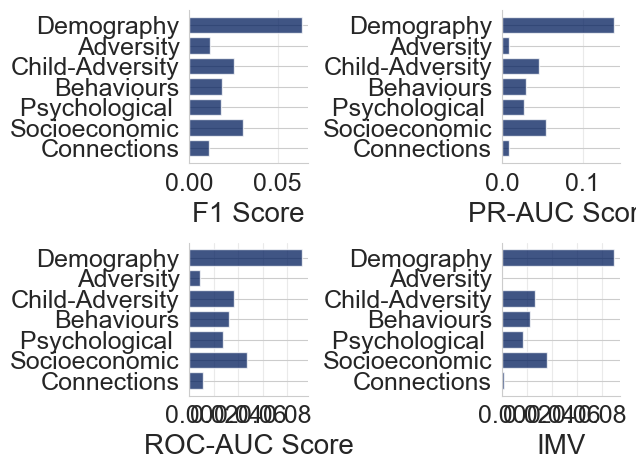

In [4]:
df = params.data_reader(dataset='HRS',source='us',bio=False)
domain_name = 'HRS'
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))

basic_domains = ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']

domains = []
for var in model_params['domain_dict'][domain_name]:
    for domain in basic_domains:
        if (var in model_params['domain_dict'][domain] )& (var not in model_params['domain_dict']['demographic']) :
            domains+=[domain]
domains = list(set(domains))+['demographic']

domain_name_lst,df_eval,iterations = get_dc_params(domains)


df_eval = dc_iteration(iterations,df_eval,df,model_params)
model_eval_diff_hrs,contribution_hrs = dd_post_process(domain_name_lst,iterations,df_eval)
dc_plot(contribution_hrs,save_control=False)
del df

## SHARE


pr_f1_contribution
pr_auc_contribution
roc_auc_contribution
imv_contribution


/Users/valler/Python/OX_Thesis/OX_thesis/src/Domains_Diff_in_combination.py:231: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[m, n].set_yticklabels([replace_name_dict[x_tick] for x_tick in contribution['goal_domain']])


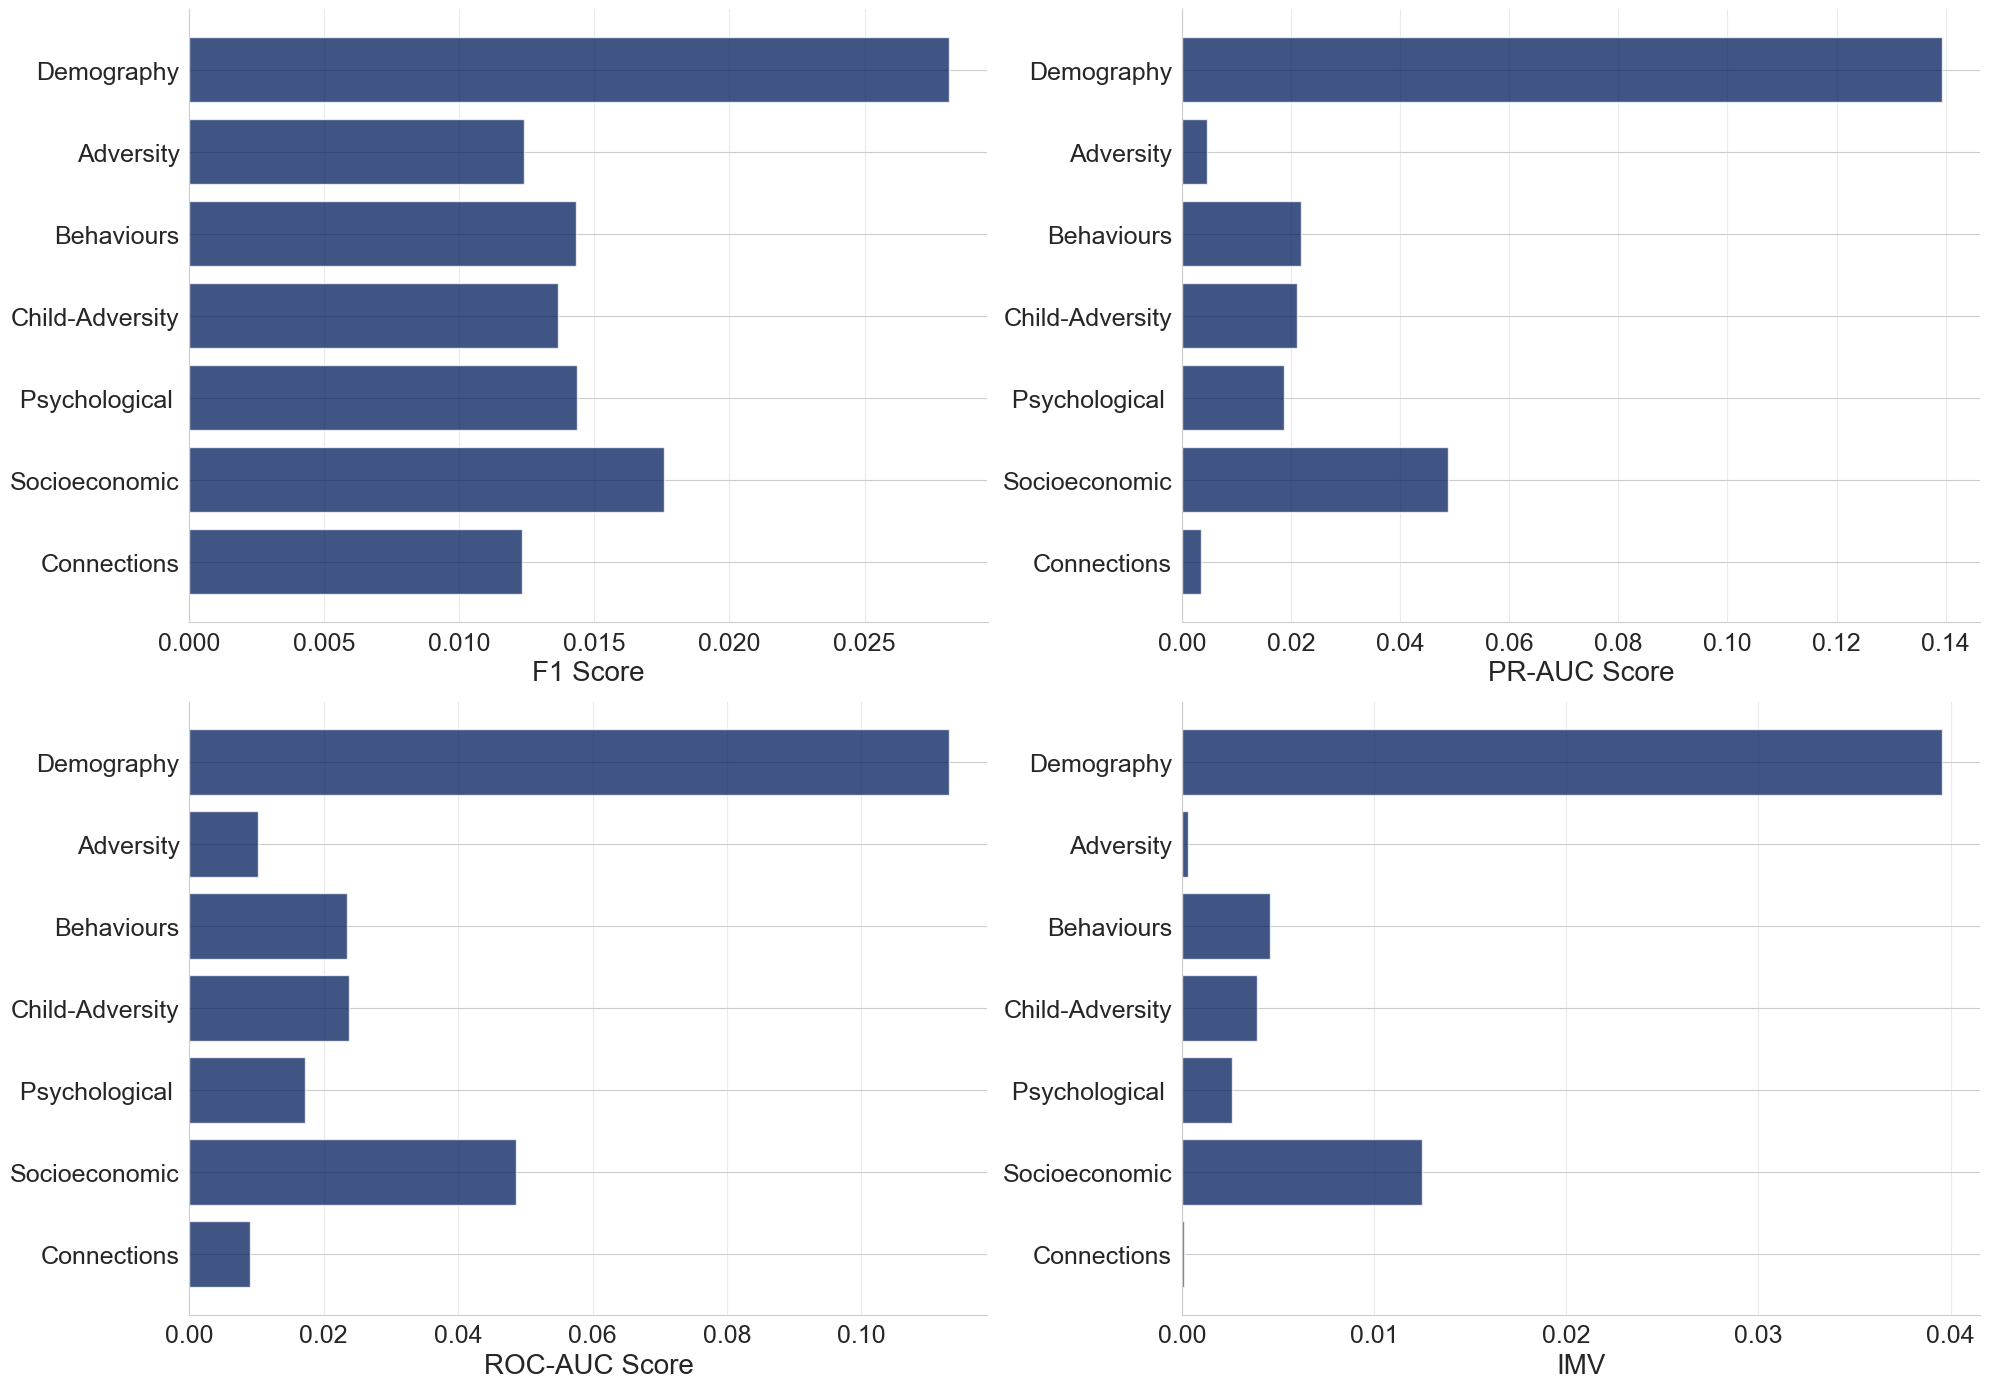

In [5]:
df = params.data_reader(dataset='SHARE',source='us',bio=False)
domain_name = 'share'
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))

basic_domains = ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']

domains = []
for var in model_params['domain_dict']['share']:
    for domain in basic_domains:
        if (var in model_params['domain_dict'][domain] )& (var not in model_params['domain_dict']['demographic']) :
            domains+=[domain]
domains = list(set(domains))+['demographic']

domain_name_lst,df_eval,iterations = get_dc_params(domains)

df_eval = dc_iteration(iterations,df_eval,df,model_params)
model_eval_diff_share,contribution_share = dd_post_process(domain_name_lst,iterations,df_eval)
dc_plot(contribution_share,save_control=False)
del df 

## ELSA

In [6]:
df = params.data_reader(dataset='ELSA',source='us',bio=False)
domain_name = 'ELSA'
model_params['domain_dict'][domain_name]= list(set(model_params['domain_dict']['all']).intersection(set(df.columns)))


there are 6 domains and 63 iterations
pr_f1_contribution
pr_auc_contribution
roc_auc_contribution
imv_contribution


/Users/valler/Python/OX_Thesis/OX_thesis/src/Domains_Diff_in_combination.py:231: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[m, n].set_yticklabels([replace_name_dict[x_tick] for x_tick in contribution['goal_domain']])


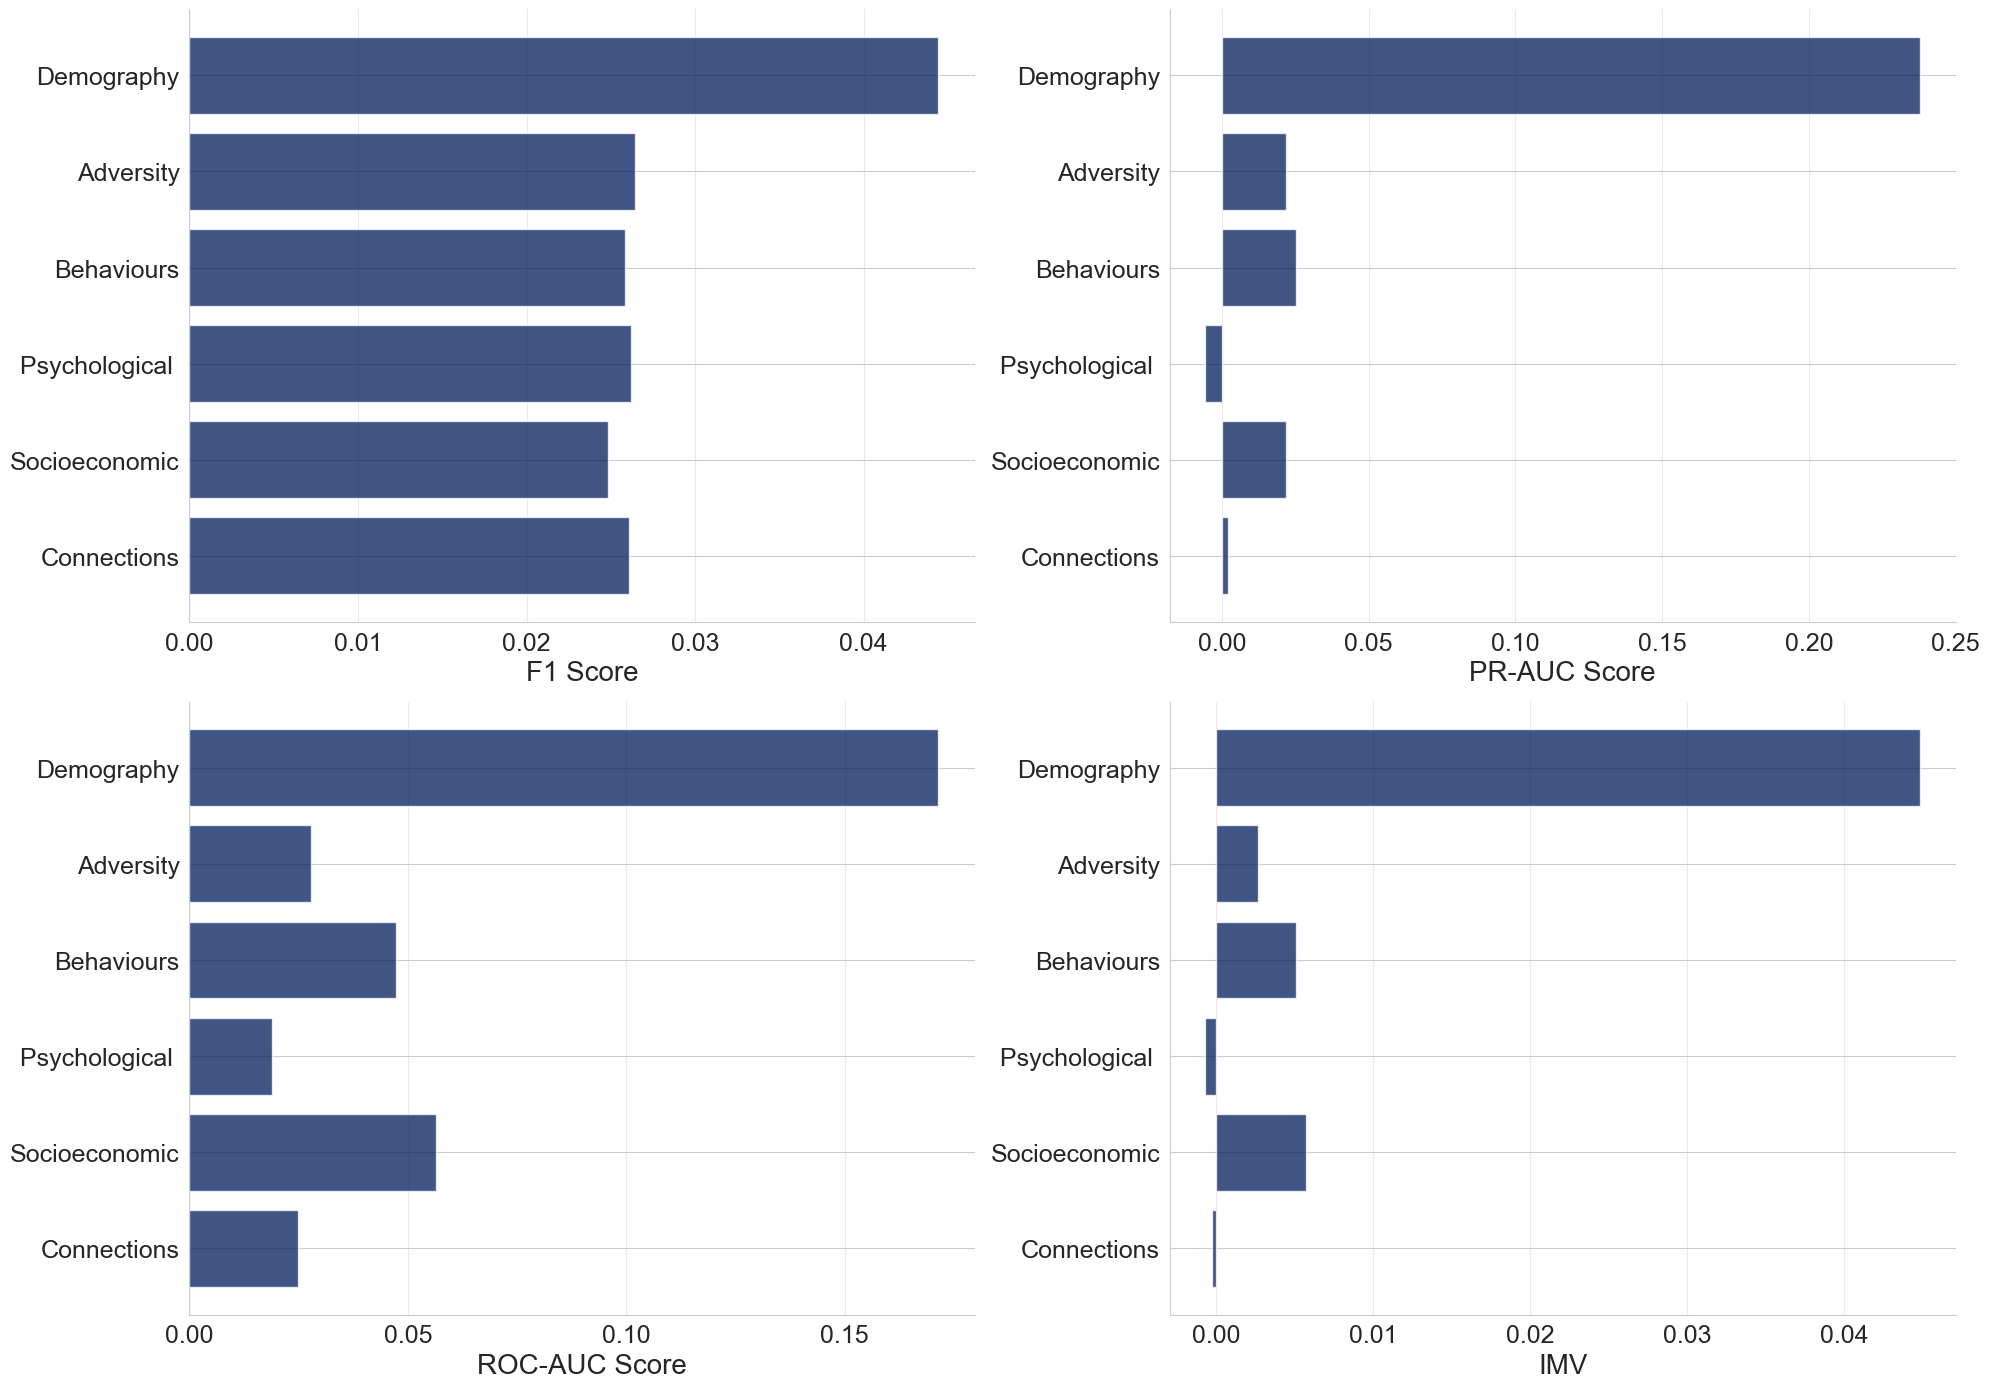

In [7]:
basic_domains = ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']

domains = []
for var in model_params['domain_dict'][domain_name]:
    for domain in basic_domains:
        if (var in model_params['domain_dict'][domain] )& (var not in model_params['domain_dict']['demographic']) :
            domains+=[domain]
domains = list(set(domains))+['demographic']

domain_name_lst,df_eval,iterations = get_dc_params(domains)
print(f'there are {len(domain_name_lst)} domains and {len(iterations)} iterations')

df_eval = dc_iteration(iterations,df_eval,df,model_params)
model_eval_diff_elsa,contribution_elsa = dd_post_process(domain_name_lst,iterations,df_eval)
dc_plot(contribution_elsa,save_control=False)
del df 

## Combination

In [8]:
comb_type = 1
domain_name = 'combination_all'
df,model_params['domain_dict'][domain_name] = params.read_merged_data(type = comb_type)
model_params['var_dict']['dataset']='Datasource'


/Users/valler/Python/OX_Thesis/OX_thesis/src/params.py:299: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df = pd.merge(left=df, right=df_ELSA, how='outer')


In [9]:
basic_domains = ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']

domains = []
for var in model_params['domain_dict'][domain_name]:
    for domain in basic_domains:
        if (var in model_params['domain_dict'][domain] )& (var not in model_params['domain_dict']['demographic']) :
            domains+=[domain]
domains = list(set(domains))+['demographic']

domain_name_lst,df_eval,iterations = get_dc_params(domains)
print(f'there are {len(domain_name_lst)} domains and {len(iterations)} iterations')

there are 4 domains and 15 iterations


pr_f1_contribution
pr_auc_contribution
roc_auc_contribution
imv_contribution


/Users/valler/Python/OX_Thesis/OX_thesis/src/Domains_Diff_in_combination.py:231: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[m, n].set_yticklabels([replace_name_dict[x_tick] for x_tick in contribution['goal_domain']])


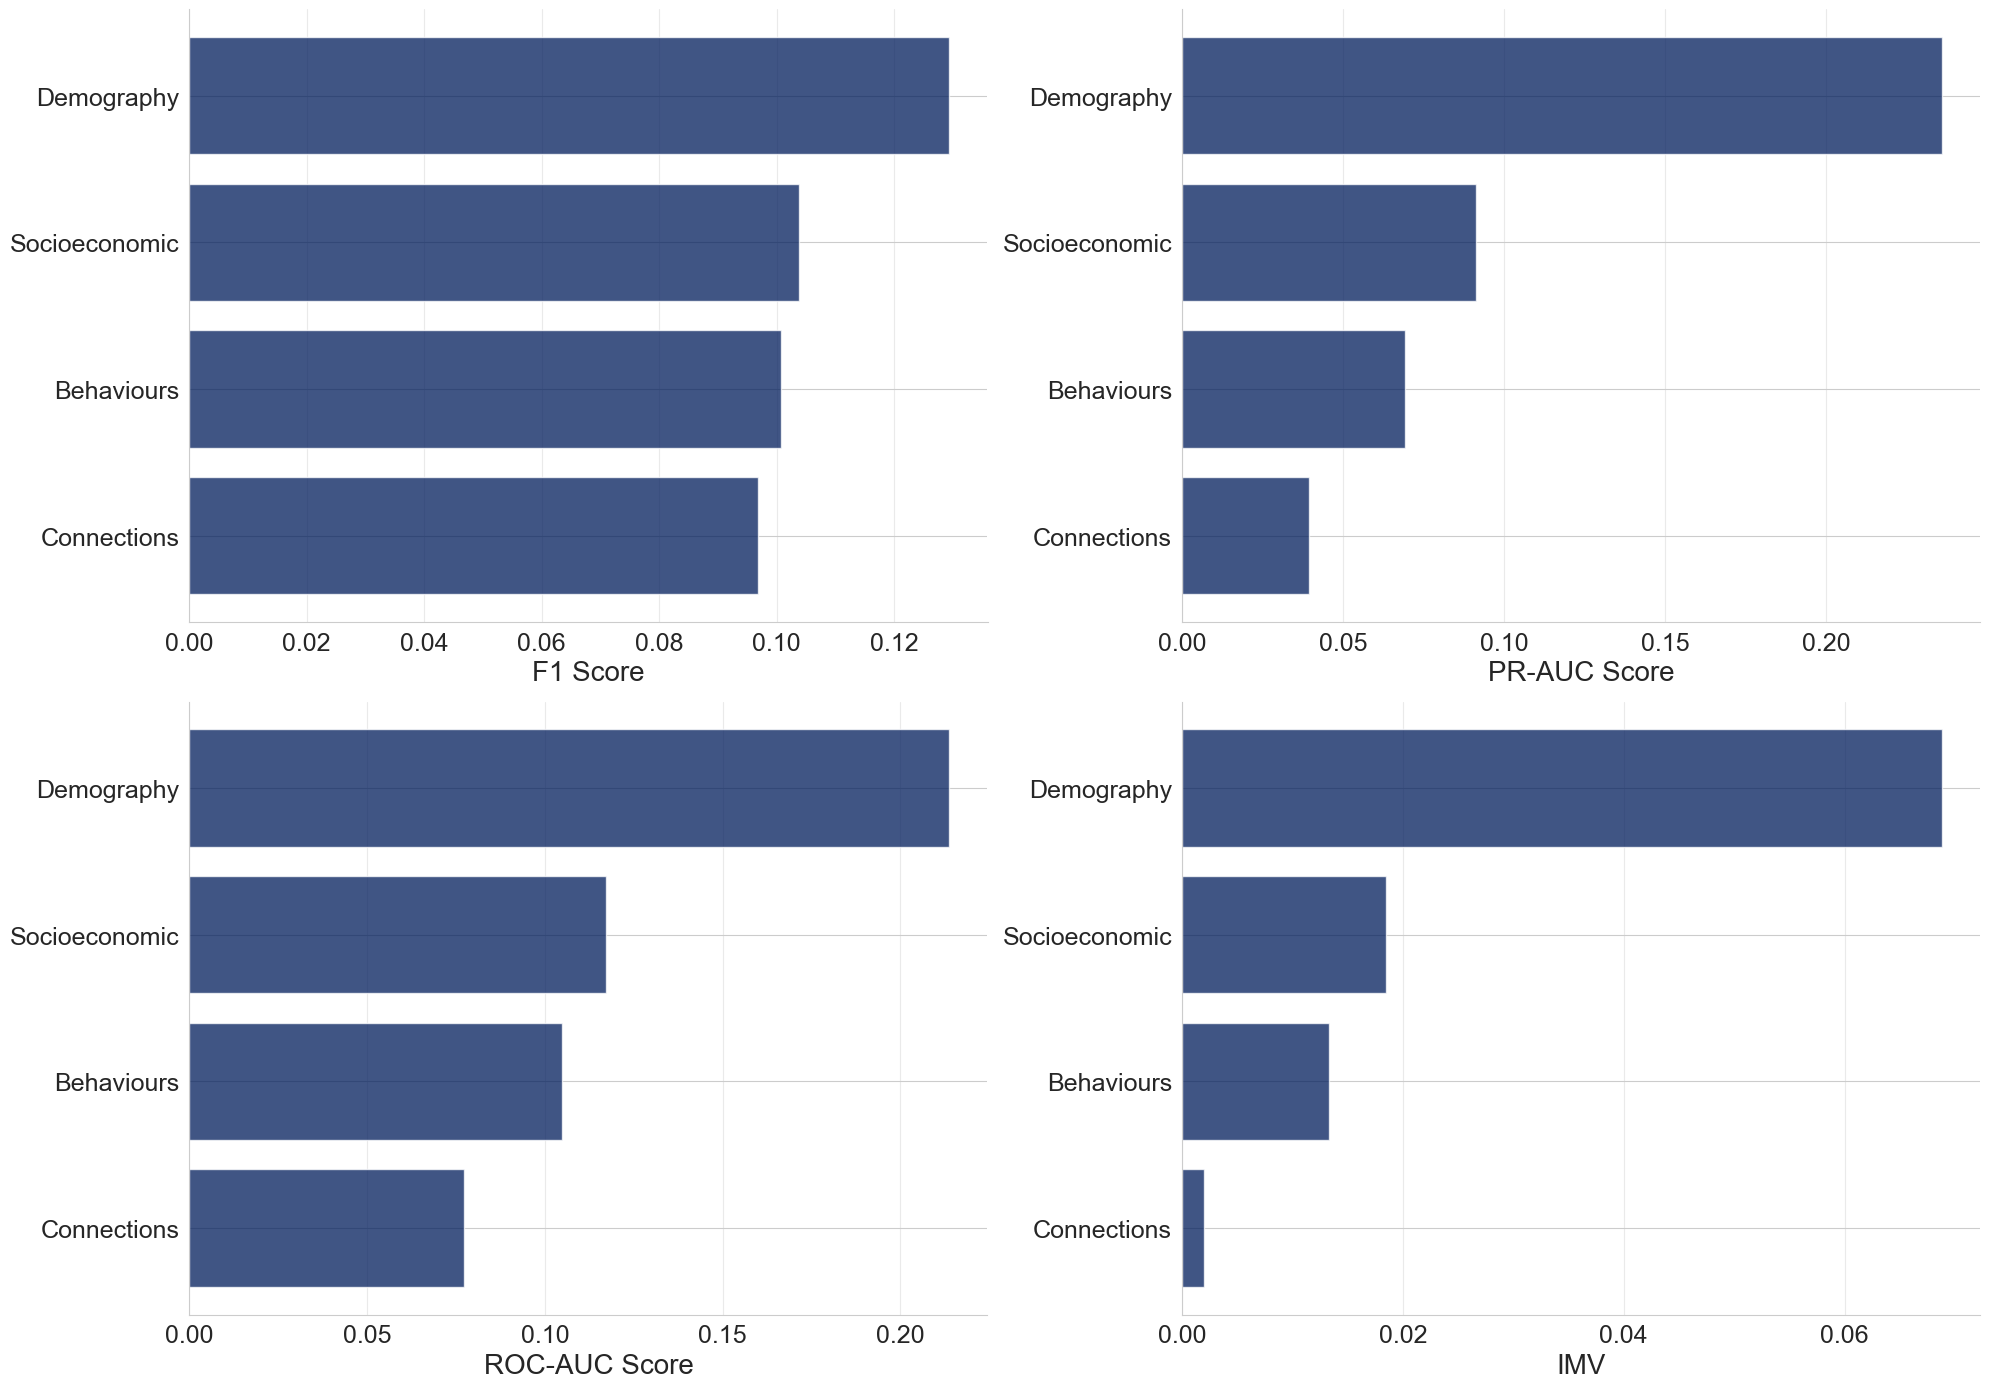

In [10]:
df_eval = dc_iteration(iterations,df_eval,df,model_params)
model_eval_diff_comb,contribution_comb = dd_post_process(domain_name_lst,iterations,df_eval)
dc_plot(contribution_comb,save_control=False)

In [12]:
from pathlib import Path
contribution_comb['dataset']='comb'
contribution_hrs['dataset']='hrs'
contribution_share['dataset']='share'
contribution_elsa['dataset']='elsa'

contribution = pd.concat([contribution_comb,contribution_hrs,contribution_share,contribution_elsa],axis=0)
contribution.to_csv(Path.cwd()/'results/domain_contribution_all_lgb_20250124.csv')

## Figrue 2: Domain Contribution

In [1]:
import pandas as pd 
from pathlib import Path
contribution=pd.read_csv(Path.cwd()/'results/domain_contribution_all_lgb_20250124.csv',index_col=0)

In [2]:
basic_domains = ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']

for domain in basic_domains:
    for dataset in contribution.dataset.unique():
        if contribution.loc[(contribution['goal_domain']==domain)&(contribution['dataset']==dataset)].shape[0]==0:
            contribution=pd.concat([contribution,pd.DataFrame({'goal_domain':[domain],'dataset':dataset,'pr_auc_contribution':[None],'roc_auc_contribution':[None],'imv_contribution':[None],'pr_f1_contribution':[None]})],axis=0)
            

In [3]:
colors = {
    'light_blue': '#a3d5e4',  # Existing light blue
    'blue': '#41678d',        # Existing blue
    'purple': '#7b6785',      # Existing purple
    'red': '#d18375',         # Existing red
    'peach': '#efb68d',       # Existing peach
    'teal': '#6aa2a3',        # New teal color
    'soft_pink': '#d19cbb',   # New soft pink color
    'warm_yellow': '#f2c46d'  # New warm yellow color
}

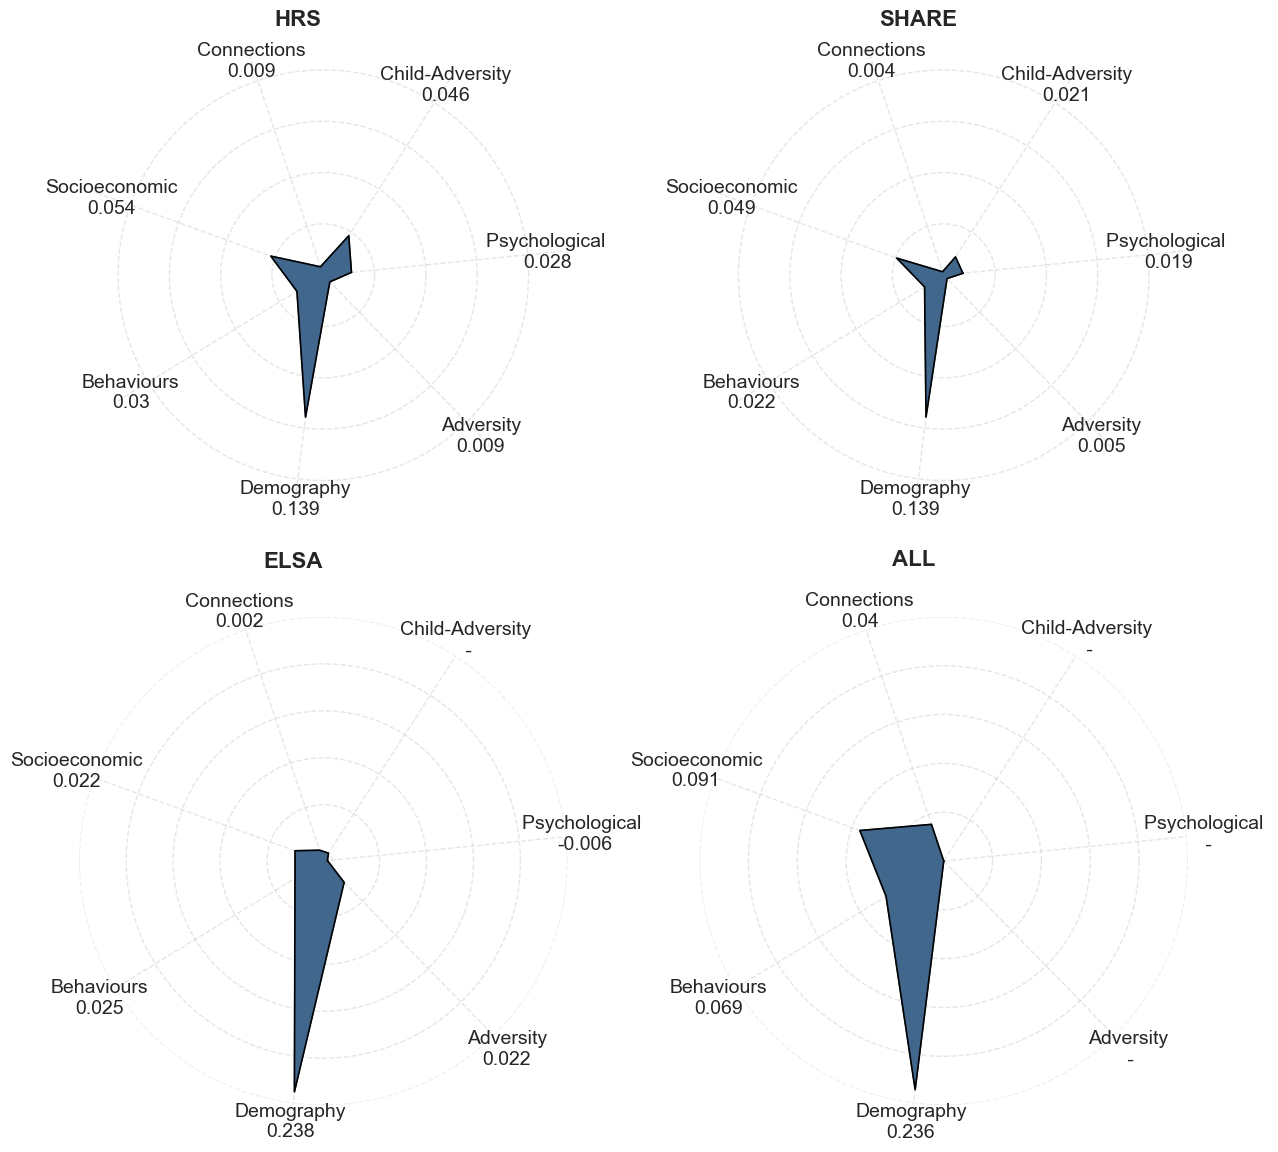

In [5]:
import matplotlib.pyplot as plt
import numpy as np

orders= {'adult_adverse': 6, 'adult_SES': 3, 'social_connection': 2, 'psych': 0, 'demographic': 5, 'behavioral': 4, 'child_adverse': 1}
replace_name_dict={'demographic':'Demography',
                       'child_adverse':'Child-Adversity',
                      'adult_SES':'Socioeconomic',
                      'behavioral':'Behaviours',
                      'adult_adverse':'Adversity',
                      'social_connection':'Connections',
                      'psych':'Psychological ',
                      'bio_adjusted':'Biomarkers',
                       'pr_f1_contribution':'F1 Score',
                       'pr_auc_contribution':'PR-AUC Score',
                      'roc_auc_contribution':'ROC-AUC Score',
                      'imv_contribution':'IMV'}
figure = plt.figure()
fontsize_ticks = 14
fontsize_labels = 16
plt.rcParams["figure.figsize"] = [13,12]
figure.subplots_adjust(left=0.12, bottom=0.1,top=0.995,right=0.995)
datasets = ['hrs','share','elsa','comb']
eva_score = 'pr_auc'

for m in range(1, 5):
    df = contribution.loc[contribution['dataset'] == datasets[m - 1]].copy()
    df['order'] = [orders[x] for x in df['goal_domain']]

    df.sort_values(by=['order'], inplace=True)
    
    # Replace NaN contributions with 0 but keep track for labels
    
    df[f'{eva_score}_contribution'].fillna(0, inplace=True)
    
    # Prepare the values for the plot
    values = list(df[f'{eva_score}_contribution'])
    values += [values[0]]
    labels = [
    replace_name_dict[x] if not np.isnan(original) else "NaN"
    for x, original in zip(df['goal_domain'], contribution[f'{eva_score}_contribution'])
]
    
    # Get the angles for the radar chart
    angles = np.linspace(0, 2 * np.pi, len(orders), endpoint=False).tolist()
    angles += angles[:1]
    angles = [x + 0.1 for x in angles]  # Close the heptagon

    # Create the subplot for each dataset
    axis = figure.add_subplot(int(f'22{m}'), polar=True)

    # Plot the heptagon shape
    axis.plot(angles, values, color='black', linewidth=1.2, linestyle='solid')
    axis.fill(angles, values, color=colors['blue'])

    # Adjust the y-axis limits
    
    
    if datasets[m - 1] == 'elsa':
        axis.set_ylim([-0.01, 0.25])
    
    elif datasets[m - 1] == 'comb':
        axis.set_ylim([0.0, 0.25])
    else:
        axis.set_ylim([0, max(contribution[f'{eva_score}_contribution'])])

    # Set the labels for each dimension

    
    axis.set_xticks(angles[:-1])
    axis.set_xticklabels([])
    
    
    axis.spines['polar'].set_visible(False)
    
    if datasets[m-1]=='comb':
        axis.text(1.67,0.31,"ALL", ha='center', va='center',fontsize=fontsize_labels,weight="bold")
    elif datasets[m-1]=='elsa':
        axis.text(1.67,0.31,datasets[m-1].upper(), ha='center', va='center',fontsize=fontsize_labels,weight="bold")
    else:
        axis.text(1.67,0.25,datasets[m-1].upper(), ha='center', va='center',fontsize=fontsize_labels,weight="bold")
    
    # Add the dimension labels
    if datasets[m-1] in ['hrs','share']:
        for i, angle in enumerate(angles[:-1]):
            x = angle
            y = 0.220
            axis.text(
                x,
                y,
                f'{labels[i]}\n{round(values[i], 3)}' if values[i]!=0 else f'{labels[i]}\n -',
                ha='center',
                va='center',
                fontsize=fontsize_ticks,
            )
    
            axis.grid(True, linestyle='dashed', linewidth=1, alpha=0.5, which='major')
            axis.set_yticklabels([])
    else:
        for i, angle in enumerate(angles[:-1]):
            x = angle
            y = 0.27
            axis.text(
                x,
                y,
                f'{labels[i]}\n{round(values[i], 3)}' if  values[i]!=0 else f'{labels[i]}\n -',
                ha='center',
                va='center',
                fontsize=fontsize_ticks,
            )
    
            axis.grid(True, linestyle='dashed', linewidth=1, alpha=0.5, which='major')
            axis.set_yticklabels([])
    # Set the aspect ratio to equal
    axis.set_aspect('equal')
    axis.set_axisbelow(True)

#figure.tight_layout()
plt.savefig(Path.cwd() / 'graphs/model_outputs/domain_contribution_all.pdf')

## Domain contribution for COMB datasets

In [11]:
import warnings
from src import params
warnings.filterwarnings("ignore")
from src.Domains_Diff_in_combination import get_dc_params,dc_iteration,dd_post_process,dc_plot
model_params = params.model_params

In [12]:
df_contribution_comb = pd.DataFrame()
for comb_type in range(1,5):

    domain_name = 'combination_all'
    df,model_params['domain_dict'][domain_name] = params.read_merged_data(type = comb_type)
    model_params['var_dict']['dataset']='Datasource'
    print(len(model_params['domain_dict'][domain_name]),model_params['domain_dict'][domain_name])

    basic_domains = ['demographic', 'child_adverse', 'adult_SES', 'behavioral', 'adult_adverse', 'social_connection', 'psych']

    domains = []
    for var in model_params['domain_dict'][domain_name]:
        for domain in basic_domains:
            if (var in model_params['domain_dict'][domain] )& (var not in model_params['domain_dict']['demographic']) :
                domains+=[domain]
    domains = list(set(domains))+['demographic']

    domain_name_lst,df_eval,iterations = get_dc_params(domains)
    print(f'for {comb_type} there are {len(domain_name_lst)} domains and {len(iterations)} iterations')

    df_eval = dc_iteration(iterations,df_eval,df,model_params)
    model_eval_diff_comb,contribution_comb = dd_post_process(domain_name_lst,iterations,df_eval)
    #dc_plot(contribution_comb,save_control=False)
    contribution_comb['dataset']=str(comb_type)
    df_contribution_comb=pd.concat([df_contribution_comb,contribution_comb],axis=0)

    comb = str(comb_type)
    for domain in basic_domains:
        if df_contribution_comb.loc[(df_contribution_comb['goal_domain']==domain)&(df_contribution_comb['dataset']==comb)].shape[0]==0:
            df_contribution_comb=pd.concat([df_contribution_comb,pd.DataFrame({'goal_domain':[domain],'dataset':[comb],'pr_auc_contribution':[None],'roc_auc_contribution':[None],'imv_contribution':[None],'pr_f1_contribution':[None]})],axis=0)


13 ['Zeduccat', 'ZwealthT', 'age', 'currsmokeYN', 'everdivorced', 'everrent', 'eversmokeYN', 'everunemployed', 'maleYN', 'migrantYN', 'nevermarried', 'rocc', 'vigactivityYN']
for 1 there are 4 domains and 15 iterations
25 ['Zeduccat', 'Zfatherseduc', 'Zhopelessness', 'Zmotherseduc', 'Znegaffect', 'Zoptimism', 'Zperceivedconstraints', 'Zpessimism', 'Zposaffect', 'ZwealthT', 'age', 'currsmokeYN', 'everdivorced', 'everrent', 'eversmokeYN', 'everunemployed', 'fathersocc', 'maleYN', 'migrantYN', 'modactivityYN', 'nevermarried', 'rocc', 'sleepYN', 'sumadultAE', 'vigactivityYN']
for 2 there are 7 domains and 127 iterations
25 ['Zdailydiscrim', 'Zeduccat', 'ZincomeT', 'Zlifesatis', 'Zloneliness', 'Znegchildren', 'Znegfamily', 'Znegfriends', 'Zneighcohesion', 'Zneighdisorder', 'Zposchildren', 'Zposfamily', 'ZwealthT', 'age', 'alcoholYN', 'currsmokeYN', 'everdivorced', 'everrent', 'eversmokeYN', 'everunemployed', 'maleYN', 'migrantYN', 'nevermarried', 'rocc', 'vigactivityYN']
for 3 there are 6 d

KeyboardInterrupt: 

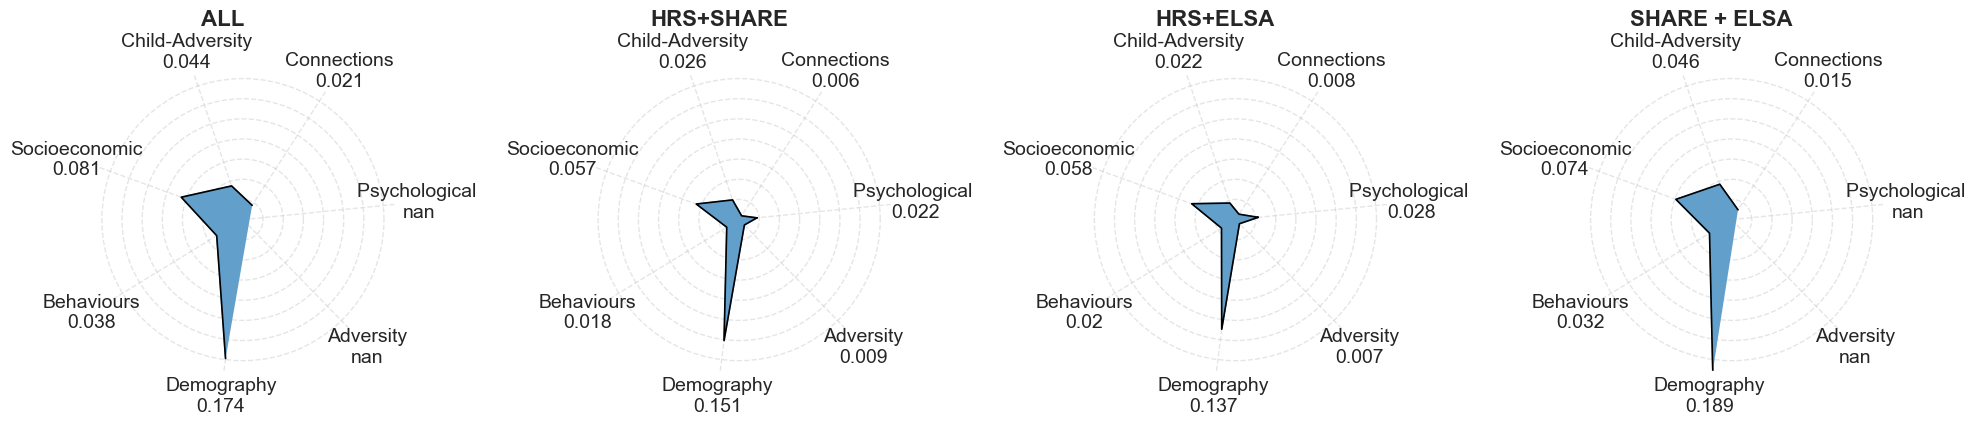

In [9]:
import matplotlib.pyplot as plt
import numpy as np

contribution = df_contribution_comb.copy()
orders= {'adult_adverse': 6, 'adult_SES': 3, 'social_connection': 1, 'psych': 0, 'demographic': 5, 'behavioral': 4, 'child_adverse': 2}
replace_name_dict={'demographic':'Demography',
                       'child_adverse':'Child-Adversity',
                      'adult_SES':'Socioeconomic',
                      'behavioral':'Behaviours',
                      'adult_adverse':'Adversity',
                      'social_connection':'Connections',
                      'psych':'Psychological ',
                      'bio_adjusted':'Biomarkers',
                       'pr_f1_contribution':'F1 Score',
                       'pr_auc_contribution':'PR-AUC Score',
                      'roc_auc_contribution':'ROC-AUC Score',
                      'imv_contribution':'IMV'}
figure = plt.figure()
fontsize_ticks = 14
fontsize_labels = 16
plt.rcParams["figure.figsize"] = [20,8]
figure.subplots_adjust(left=0.12, bottom=0.1,top=0.995,right=0.995)
datasets = [str(x) for x in range(1,5)]

dataset_name_dict= { '1':'All','2':'HRS+SHARE','3':'HRS+ELSA','4':'SHARE + ELSA'}


for m in range(1,5):
    df = contribution.loc[contribution['dataset']==datasets[m-1]].copy()
    df['order']=[orders[x] for x in df['goal_domain']]

    df.sort_values(by=['order'],inplace=True)

    #df.drop(columns=['order'],inplace=True)

    eva_score = 'pr_auc'


    values = list(df[f'{eva_score}_contribution'])
    values += [values[0]]

    labels = [replace_name_dict[x] for x in df['goal_domain']]

    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]
    angles = [x+0.1 for x in angles] # Close the heptagon

    axis = figure.add_subplot(1, 4, m, polar=True)

    # Plot the heptagon shape
    axis.plot(angles, values, color='black', linewidth=1.2, linestyle='solid')
    axis.fill(angles, values, color=colors['blue'])


    axis.set_ylim([0, max(contribution[f'{eva_score}_contribution'])])


    if datasets[m-1]=='elsa':
        print(values)
        axis.set_ylim([-0.01, max(contribution[f'{eva_score}_contribution'])])


    # Set the labels for each dimension
    axis.set_xticks(angles[:-1])
    axis.set_xticklabels([])



    axis.spines['polar'].set_visible(False)
    # ax.spines['polar'].set_alpha(0.1)

    # set title
    if datasets[m-1]=='comb':
        axis.text(1.67,0.25,"HRS + ELSA", ha='center', va='center',fontsize=fontsize_labels,weight="bold")
    else:
        axis.text(1.67,0.25,dataset_name_dict[str(m)].upper(), ha='center', va='center',fontsize=fontsize_labels,weight="bold")


    # Add the dimension labels
    for i, angle in enumerate(angles[:-1]):
        x = angle
        y = 0.220
        axis.text(x, y, f'{labels[i]}\n{round(values[i],3)}', ha='center', va='center',fontsize=fontsize_ticks)
        axis.grid(True, linestyle='dashed', linewidth=1, alpha=0.5,which='major')
        axis.set_yticklabels([])


    # Set the aspect ratio to equal
    axis.set_aspect('equal')
    axis.set_axisbelow(True)
figure.tight_layout()
# Show the plot
# plt.savefig(Path.cwd() / 'graphs/model_outputs/domain_contribution_all_combined_datasets.pdf')
plt.show()

df_contribution_comb

# Asymptotics


In [2]:
from src import params
import pandas as pd
from src import Models
from pathlib import Path
from src.Evaluate import metric,print_model_fits,sl_eva,ffc_rsquare,efron_rsquare
from src import Shap
from src import SuperLearner
import random 

model_params = params.model_params


## LightGBM Version 

In [1]:
import os
import pathlib
import sys
from src import params
import pandas as pd
from src import Models
from pathlib import Path
from src.Evaluate import metric,print_model_fits,sl_eva
from src import Shap
from src import SuperLearner
from src import params
import numpy as np
import pandas as pd
from src.Evaluate import sl_only_eva
from src import SuperLearner
import random

model_params = params.model_params

In [2]:
# read data 
df,domain_lst = params.read_merged_data(type=3)
domain_name = 'combine_all'
model_params['domain_dict'][domain_name]=domain_lst

In [3]:


# specification
model_name='lgb'
model_params = params.model_params
model_params['k'] = 5
model_params['y_colname'] = 'death'
domain_name = 'combination_all'

model_params['domain_dict'][domain_name] = ['Zpessimism', 'everunemployed', 'Zperceivedconstraints', 'Zmotherseduc', 'rocc', 'nevermarried', 'ZwealthT', 'age', 'everrent', 'dataset', 'Zoptimism', 'maleYN', 'Znegaffect', 'sleepYN', 'migrantYN', 'fathersocc', 'Zfatherseduc', 'everdivorced', 'Zposaffect', 'currsmokeYN', 'Zhopelessness', 'eversmokeYN', 'Zeduccat', 'modactivityYN', 'vigactivityYN', 'sumadultAE']
model_params['var_dict']['dataset']='Datasource'

# sl initialisation
start = float(0.3)
end = float(1.05)
step=0.05
model='lgb'
seeds = [1981236101, 56317909029, 91833472504,6588504046385,6747454181206,2069405004429]
var_set = model_params['domain_dict'][domain_name]
Eva_fixed_test_size_lgb = pd.DataFrame(columns=['model', 'var_num','train_subset_size', 'test_auc_score', 'test_f1_score', 'test_pr_auc', 'test_pr_no_skill', 'test_efron_r2', 'test_ffc_r2','test_briern_r2', 'test_imv_r2','training_seed'])


In [4]:

for seed_ind in range(0,len(seeds)):
    Eva_fixed_test_size_lgb = pd.DataFrame(columns=['model', 'var_num','train_subset_size', 'test_auc_score', 'test_f1_score', 'test_pr_auc', 'test_pr_no_skill', 'test_efron_r2', 'test_ffc_r2','test_briern_r2', 'test_imv_r2','training_seed'])


    for train_subset_size in np.arange(start, end, step):

        for sub_set_size in range(1, len(var_set) + 1):
            print(train_subset_size, sub_set_size)
            random.seed(seed_ind)  #
            model_params['domain_dict']['sub_set'] = random.sample(var_set, sub_set_size)
            seed = random.randint(a=1, b=4294967295)
            model_params['random_state'] = seed
            domain_list=model_params['domain_dict']['sub_set']
            model_params['train_on_ELSA_first']=True
            #superlearner = SuperLearner.superlearner(data=df,
            #                                         train_subset_size=train_subset_size,
            #                                         test_size=model_params['test_size'],
            #                                         domain_list=model_params['domain_dict']['sub_set'],
            #                                         y_colname=model_params['y_colname'],
            #                                         k=model_params['k'],
            #                                         random_state=model_params['random_state'])


            model = Models.Model_fixed_test_size(data=df, 
                                                 model_params=model_params, 
                                                 domain=model_params['domain_dict']['sub_set'], 
                                                 model=model_name, 
                                                 train_subset_size=train_subset_size, 
                                                 order=0,)

            evas=metric(model)
            # df_eva.loc[len(df_eva)] = [model, pr_auc, roc_auc, f1, efron, ffc, ip, imv_]
            Eva_fixed_test_size_lgb.loc[len(Eva_fixed_test_size_lgb)] = ['lgb',
                                                                       sub_set_size,
                                                                       int(len(df) * train_subset_size),
                                                                       evas.auc_score,
                                                                       evas.pr_f1,
                                                                       evas.pr_auc,
                                                                       evas.pr_no_skill,
                                                                       evas.efron_rsquare,
                                                                       evas.ffc_r2,
                                                                       evas.brier,
                                                                       evas.imv,
                                                                       seed]

            Eva_fixed_test_size_lgb.to_csv(f"{os.getcwd()}/results/asymptotics_lgb_with_random_sampling_on_vars_seed_specified_{start}_{end}_{seed_ind}{'_train_on_ELSA_first' if model_params['train_on_ELSA_first'] else ''}.csv",index=False)


0.3 1
0.3 2
0.3 3
0.3 4
0.3 5
0.3 6
0.3 7
0.3 8
0.3 9
0.3 10
0.3 11
0.3 12
0.3 13
0.3 14
0.3 15
0.3 16
0.3 17
0.3 18
0.3 19
0.3 20
0.3 21
0.3 22
0.3 23
0.3 24
0.3 25
0.3 26
0.35 1
0.35 2
0.35 3
0.35 4
0.35 5
0.35 6
0.35 7
0.35 8
0.35 9
0.35 10
0.35 11
0.35 12
0.35 13
0.35 14
0.35 15
0.35 16
0.35 17
0.35 18
0.35 19
0.35 20
0.35 21
0.35 22
0.35 23
0.35 24
0.35 25
0.35 26
0.39999999999999997 1
0.39999999999999997 2
0.39999999999999997 3
0.39999999999999997 4
0.39999999999999997 5
0.39999999999999997 6
0.39999999999999997 7
0.39999999999999997 8
0.39999999999999997 9
0.39999999999999997 10
0.39999999999999997 11
0.39999999999999997 12
0.39999999999999997 13
0.39999999999999997 14
0.39999999999999997 15
0.39999999999999997 16
0.39999999999999997 17
0.39999999999999997 18
0.39999999999999997 19
0.39999999999999997 20
0.39999999999999997 21
0.39999999999999997 22
0.39999999999999997 23
0.39999999999999997 24
0.39999999999999997 25
0.39999999999999997 26
0.44999999999999996 1
0.449999999999999

0.44999999999999996 11
0.44999999999999996 12
0.44999999999999996 13
0.44999999999999996 14
0.44999999999999996 15
0.44999999999999996 16
0.44999999999999996 17
0.44999999999999996 18
0.44999999999999996 19
0.44999999999999996 20
0.44999999999999996 21
0.44999999999999996 22
0.44999999999999996 23
0.44999999999999996 24
0.44999999999999996 25
0.44999999999999996 26
0.49999999999999994 1
0.49999999999999994 2
0.49999999999999994 3
0.49999999999999994 4
0.49999999999999994 5
0.49999999999999994 6
0.49999999999999994 7
0.49999999999999994 8
0.49999999999999994 9
0.49999999999999994 10
0.49999999999999994 11
0.49999999999999994 12
0.49999999999999994 13
0.49999999999999994 14
0.49999999999999994 15
0.49999999999999994 16
0.49999999999999994 17
0.49999999999999994 18
0.49999999999999994 19
0.49999999999999994 20
0.49999999999999994 21
0.49999999999999994 22
0.49999999999999994 23
0.49999999999999994 24
0.49999999999999994 25
0.49999999999999994 26
0.5499999999999999 1
0.5499999999999999 2
0

0.5499999999999999 13
0.5499999999999999 14
0.5499999999999999 15
0.5499999999999999 16
0.5499999999999999 17
0.5499999999999999 18
0.5499999999999999 19
0.5499999999999999 20
0.5499999999999999 21
0.5499999999999999 22
0.5499999999999999 23
0.5499999999999999 24
0.5499999999999999 25
0.5499999999999999 26
0.5999999999999999 1
0.5999999999999999 2
0.5999999999999999 3
0.5999999999999999 4
0.5999999999999999 5
0.5999999999999999 6
0.5999999999999999 7
0.5999999999999999 8
0.5999999999999999 9
0.5999999999999999 10
0.5999999999999999 11
0.5999999999999999 12
0.5999999999999999 13
0.5999999999999999 14
0.5999999999999999 15
0.5999999999999999 16
0.5999999999999999 17
0.5999999999999999 18
0.5999999999999999 19
0.5999999999999999 20
0.5999999999999999 21
0.5999999999999999 22
0.5999999999999999 23
0.5999999999999999 24
0.5999999999999999 25
0.5999999999999999 26
0.6499999999999999 1
0.6499999999999999 2
0.6499999999999999 3
0.6499999999999999 4
0.6499999999999999 5
0.6499999999999999 6
0.6

divide by zero encountered in double_scalars


0.3 20
0.3 21
0.3 22
0.3 23
0.3 24
0.3 25
0.3 26
0.35 1
0.35 2
0.35 3
0.35 4
0.35 5
0.35 6
0.35 7
0.35 8
0.35 9
0.35 10
0.35 11
0.35 12
0.35 13
0.35 14
0.35 15
0.35 16
0.35 17
0.35 18
0.35 19


divide by zero encountered in double_scalars


0.35 20
0.35 21
0.35 22
0.35 23
0.35 24
0.35 25
0.35 26
0.39999999999999997 1
0.39999999999999997 2
0.39999999999999997 3
0.39999999999999997 4
0.39999999999999997 5
0.39999999999999997 6
0.39999999999999997 7
0.39999999999999997 8
0.39999999999999997 9
0.39999999999999997 10
0.39999999999999997 11
0.39999999999999997 12
0.39999999999999997 13
0.39999999999999997 14
0.39999999999999997 15
0.39999999999999997 16
0.39999999999999997 17
0.39999999999999997 18
0.39999999999999997 19


divide by zero encountered in double_scalars


0.39999999999999997 20
0.39999999999999997 21
0.39999999999999997 22
0.39999999999999997 23
0.39999999999999997 24
0.39999999999999997 25
0.39999999999999997 26
0.44999999999999996 1
0.44999999999999996 2
0.44999999999999996 3
0.44999999999999996 4
0.44999999999999996 5
0.44999999999999996 6
0.44999999999999996 7
0.44999999999999996 8
0.44999999999999996 9
0.44999999999999996 10
0.44999999999999996 11
0.44999999999999996 12
0.44999999999999996 13
0.44999999999999996 14
0.44999999999999996 15
0.44999999999999996 16
0.44999999999999996 17
0.44999999999999996 18
0.44999999999999996 19


divide by zero encountered in double_scalars


0.44999999999999996 20
0.44999999999999996 21
0.44999999999999996 22
0.44999999999999996 23
0.44999999999999996 24
0.44999999999999996 25
0.44999999999999996 26
0.49999999999999994 1
0.49999999999999994 2
0.49999999999999994 3
0.49999999999999994 4
0.49999999999999994 5
0.49999999999999994 6
0.49999999999999994 7
0.49999999999999994 8
0.49999999999999994 9
0.49999999999999994 10
0.49999999999999994 11
0.49999999999999994 12
0.49999999999999994 13
0.49999999999999994 14
0.49999999999999994 15
0.49999999999999994 16
0.49999999999999994 17
0.49999999999999994 18
0.49999999999999994 19


divide by zero encountered in double_scalars


0.49999999999999994 20
0.49999999999999994 21
0.49999999999999994 22
0.49999999999999994 23
0.49999999999999994 24
0.49999999999999994 25
0.49999999999999994 26
0.5499999999999999 1
0.5499999999999999 2
0.5499999999999999 3
0.5499999999999999 4
0.5499999999999999 5
0.5499999999999999 6
0.5499999999999999 7
0.5499999999999999 8
0.5499999999999999 9
0.5499999999999999 10
0.5499999999999999 11
0.5499999999999999 12
0.5499999999999999 13
0.5499999999999999 14
0.5499999999999999 15
0.5499999999999999 16
0.5499999999999999 17
0.5499999999999999 18
0.5499999999999999 19


divide by zero encountered in double_scalars


0.5499999999999999 20
0.5499999999999999 21
0.5499999999999999 22
0.5499999999999999 23
0.5499999999999999 24
0.5499999999999999 25
0.5499999999999999 26
0.5999999999999999 1
0.5999999999999999 2
0.5999999999999999 3
0.5999999999999999 4
0.5999999999999999 5
0.5999999999999999 6
0.5999999999999999 7
0.5999999999999999 8
0.5999999999999999 9
0.5999999999999999 10
0.5999999999999999 11
0.5999999999999999 12
0.5999999999999999 13
0.5999999999999999 14
0.5999999999999999 15
0.5999999999999999 16
0.5999999999999999 17
0.5999999999999999 18
0.5999999999999999 19


divide by zero encountered in double_scalars


0.5999999999999999 20
0.5999999999999999 21
0.5999999999999999 22
0.5999999999999999 23
0.5999999999999999 24
0.5999999999999999 25
0.5999999999999999 26
0.6499999999999999 1
0.6499999999999999 2
0.6499999999999999 3
0.6499999999999999 4
0.6499999999999999 5
0.6499999999999999 6
0.6499999999999999 7
0.6499999999999999 8
0.6499999999999999 9
0.6499999999999999 10
0.6499999999999999 11
0.6499999999999999 12
0.6499999999999999 13
0.6499999999999999 14
0.6499999999999999 15
0.6499999999999999 16
0.6499999999999999 17
0.6499999999999999 18
0.6499999999999999 19


divide by zero encountered in double_scalars


0.6499999999999999 20
0.6499999999999999 21
0.6499999999999999 22
0.6499999999999999 23
0.6499999999999999 24
0.6499999999999999 25
0.6499999999999999 26
0.7 1
0.7 2
0.7 3
0.7 4
0.7 5
0.7 6
0.7 7
0.7 8
0.7 9
0.7 10
0.7 11
0.7 12
0.7 13
0.7 14
0.7 15
0.7 16
0.7 17
0.7 18
0.7 19


divide by zero encountered in double_scalars


0.7 20
0.7 21
0.7 22
0.7 23
0.7 24
0.7 25
0.7 26
0.7499999999999999 1
0.7499999999999999 2
0.7499999999999999 3
0.7499999999999999 4
0.7499999999999999 5
0.7499999999999999 6
0.7499999999999999 7
0.7499999999999999 8
0.7499999999999999 9
0.7499999999999999 10
0.7499999999999999 11
0.7499999999999999 12
0.7499999999999999 13
0.7499999999999999 14
0.7499999999999999 15
0.7499999999999999 16
0.7499999999999999 17
0.7499999999999999 18
0.7499999999999999 19


divide by zero encountered in double_scalars


0.7499999999999999 20
0.7499999999999999 21
0.7499999999999999 22
0.7499999999999999 23
0.7499999999999999 24
0.7499999999999999 25
0.7499999999999999 26
0.7999999999999998 1
0.7999999999999998 2
0.7999999999999998 3
0.7999999999999998 4
0.7999999999999998 5
0.7999999999999998 6
0.7999999999999998 7
0.7999999999999998 8
0.7999999999999998 9
0.7999999999999998 10
0.7999999999999998 11
0.7999999999999998 12
0.7999999999999998 13
0.7999999999999998 14
0.7999999999999998 15
0.7999999999999998 16
0.7999999999999998 17
0.7999999999999998 18
0.7999999999999998 19


divide by zero encountered in double_scalars


0.7999999999999998 20
0.7999999999999998 21
0.7999999999999998 22
0.7999999999999998 23
0.7999999999999998 24
0.7999999999999998 25
0.7999999999999998 26
0.8499999999999999 1
0.8499999999999999 2
0.8499999999999999 3
0.8499999999999999 4
0.8499999999999999 5
0.8499999999999999 6
0.8499999999999999 7
0.8499999999999999 8
0.8499999999999999 9
0.8499999999999999 10
0.8499999999999999 11
0.8499999999999999 12
0.8499999999999999 13
0.8499999999999999 14
0.8499999999999999 15
0.8499999999999999 16
0.8499999999999999 17
0.8499999999999999 18
0.8499999999999999 19


divide by zero encountered in double_scalars


0.8499999999999999 20
0.8499999999999999 21
0.8499999999999999 22
0.8499999999999999 23
0.8499999999999999 24
0.8499999999999999 25
0.8499999999999999 26
0.8999999999999999 1
0.8999999999999999 2
0.8999999999999999 3
0.8999999999999999 4
0.8999999999999999 5
0.8999999999999999 6
0.8999999999999999 7
0.8999999999999999 8
0.8999999999999999 9
0.8999999999999999 10
0.8999999999999999 11
0.8999999999999999 12
0.8999999999999999 13
0.8999999999999999 14
0.8999999999999999 15
0.8999999999999999 16
0.8999999999999999 17
0.8999999999999999 18
0.8999999999999999 19


divide by zero encountered in double_scalars


0.8999999999999999 20
0.8999999999999999 21
0.8999999999999999 22
0.8999999999999999 23
0.8999999999999999 24
0.8999999999999999 25
0.8999999999999999 26
0.95 1
0.95 2
0.95 3
0.95 4
0.95 5
0.95 6
0.95 7
0.95 8
0.95 9
0.95 10
0.95 11
0.95 12
0.95 13
0.95 14
0.95 15
0.95 16
0.95 17
0.95 18
0.95 19


divide by zero encountered in double_scalars


0.95 20
0.95 21
0.95 22
0.95 23
0.95 24
0.95 25
0.95 26
0.9999999999999998 1
0.9999999999999998 2
0.9999999999999998 3
0.9999999999999998 4
0.9999999999999998 5
0.9999999999999998 6
0.9999999999999998 7
0.9999999999999998 8
0.9999999999999998 9
0.9999999999999998 10
0.9999999999999998 11
0.9999999999999998 12
0.9999999999999998 13
0.9999999999999998 14
0.9999999999999998 15
0.9999999999999998 16
0.9999999999999998 17
0.9999999999999998 18
0.9999999999999998 19


divide by zero encountered in double_scalars


0.9999999999999998 20
0.9999999999999998 21
0.9999999999999998 22
0.9999999999999998 23
0.9999999999999998 24
0.9999999999999998 25
0.9999999999999998 26
0.3 1
0.3 2
0.3 3
0.3 4
0.3 5
0.3 6
0.3 7
0.3 8
0.3 9
0.3 10
0.3 11
0.3 12
0.3 13
0.3 14
0.3 15
0.3 16
0.3 17
0.3 18
0.3 19
0.3 20
0.3 21
0.3 22
0.3 23
0.3 24
0.3 25
0.3 26
0.35 1
0.35 2
0.35 3
0.35 4
0.35 5
0.35 6
0.35 7
0.35 8
0.35 9
0.35 10
0.35 11
0.35 12
0.35 13
0.35 14
0.35 15
0.35 16
0.35 17
0.35 18
0.35 19
0.35 20
0.35 21
0.35 22
0.35 23
0.35 24
0.35 25
0.35 26
0.39999999999999997 1
0.39999999999999997 2
0.39999999999999997 3
0.39999999999999997 4
0.39999999999999997 5
0.39999999999999997 6
0.39999999999999997 7
0.39999999999999997 8
0.39999999999999997 9
0.39999999999999997 10
0.39999999999999997 11
0.39999999999999997 12
0.39999999999999997 13
0.39999999999999997 14
0.39999999999999997 15
0.39999999999999997 16
0.39999999999999997 17
0.39999999999999997 18
0.39999999999999997 19
0.39999999999999997 20
0.39999999999999997 21


0.44999999999999996 5
0.44999999999999996 6
0.44999999999999996 7
0.44999999999999996 8
0.44999999999999996 9
0.44999999999999996 10
0.44999999999999996 11
0.44999999999999996 12
0.44999999999999996 13
0.44999999999999996 14
0.44999999999999996 15
0.44999999999999996 16
0.44999999999999996 17
0.44999999999999996 18
0.44999999999999996 19
0.44999999999999996 20
0.44999999999999996 21
0.44999999999999996 22
0.44999999999999996 23
0.44999999999999996 24
0.44999999999999996 25
0.44999999999999996 26
0.49999999999999994 1
0.49999999999999994 2
0.49999999999999994 3
0.49999999999999994 4
0.49999999999999994 5
0.49999999999999994 6
0.49999999999999994 7
0.49999999999999994 8
0.49999999999999994 9
0.49999999999999994 10
0.49999999999999994 11
0.49999999999999994 12
0.49999999999999994 13
0.49999999999999994 14
0.49999999999999994 15
0.49999999999999994 16
0.49999999999999994 17
0.49999999999999994 18
0.49999999999999994 19
0.49999999999999994 20
0.49999999999999994 21
0.49999999999999994 22
0.

## Lightgbm plot

In [119]:
# graphs 
import os 
seeds = [1981236101, 56317909029, 91833472504,6588504046385,6747454181206,2069405004429]
files = [x for x in os.listdir(Path.cwd()/f'results' )if x.startswith(f'asymptotics_lgb_with_random_sampling_on_vars_seed_specified_')]

In [120]:
train_on_ELSA_first = True 
if train_on_ELSA_first:
    files = [x for x in files if "_train_on_ELSA_first" in x]
else:
    files = [x for x in files if "_train_on_ELSA_first" not in x]

In [121]:
df = pd.DataFrame()
for file in files:
    if train_on_ELSA_first:
        file_num = int(file[len(file)-25:len(file)-24])
    else:
        file_num = int(file[len(file)-5:len(file)-4])
     
    temp = pd.read_csv(Path.cwd()/f'results/{file}')
    temp['sample_seed'] = seeds[file_num]
    #if file  == 'asymptotics_sl_with_random_sampling_on_vars_seed_specified_0.3_0.4_0.csv':
    #    temp = temp.loc[~temp['train_subset_size']== 22766]
    df = pd.concat([df,temp],axis=0)
    del(temp)


df_avg = df.groupby(['var_num','train_subset_size']).mean()
df_avg.reset_index(inplace=True)

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


In [136]:
import matplotlib.colors as mcolors

# Define the colors
colors_blue_purple = ['#41678d', '#d18375','#efb68d']  # blue to purple
# ,'#d18375',
# Create a colormap
cmap_blue_purple = mcolors.LinearSegmentedColormap.from_list("blue_to_purple", colors_blue_purple)


In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.


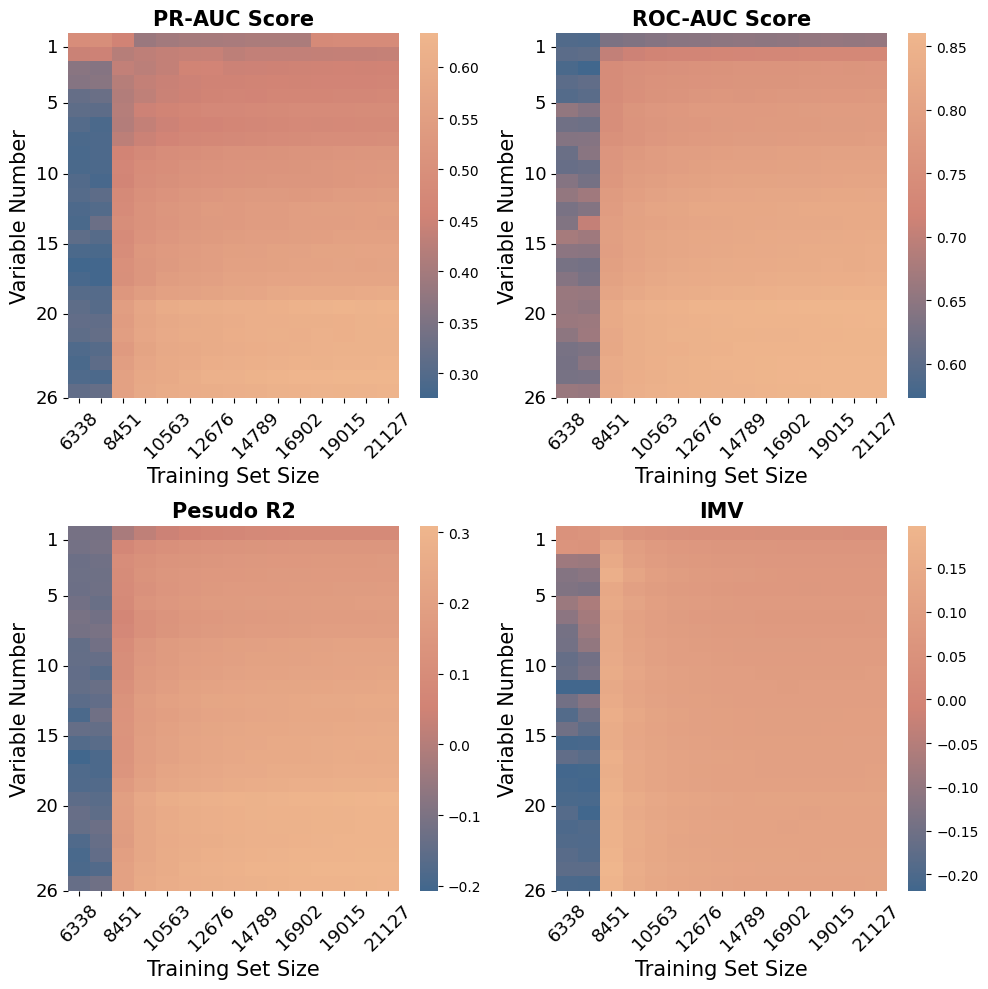

In [138]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_avg is already defined and contains the relevant data

columns = []
for column in df.columns:
    if 'test' in column:
        columns.append(column)

df_to_plot = df_avg.drop_duplicates(subset=['train_subset_size', 'var_num']).copy()
df_to_plot.reset_index(inplace=True, drop=True)

# Removing specific columns
columns.remove('test_f1_score')
columns.remove('test_pr_no_skill')
columns.remove('test_ffc_r2')
columns.remove('test_briern_r2')

ploted_col_dict = {
    'test_efron_r2': 'Pesudo R2',
    'test_pr_auc': 'PR-AUC Score',
    'test_auc_score': 'ROC-AUC Score',
    'test_imv_r2': 'IMV'
}

fig, axis = plt.subplots(2, 2)
fontsize_ticks = 13
fontsize_labels = 15
fig.subplots_adjust(left=0.08, bottom=0.08, top=0.95, right=0.99)
plt.rcParams['figure.figsize'] = [10, 10]

x_ticks = [22766, 28458, 34150, 39841, 45533, 51225, 56917]
count = 0
columns = ['test_pr_auc', 'test_auc_score', 'test_efron_r2', 'test_imv_r2']

for (m, n), subplot in np.ndenumerate(axis):
    metric = columns[count]
    
    # Apply logarithmic scale to the metric data
    # df_to_plot[metric] = np.log1p(df_to_plot[metric])  # Using log1p for log(1 + x) to handle zero values
    
    pivot_table = df_to_plot.pivot('var_num', 'train_subset_size', metric)
    
    # Using a red-blue colormap
    sns.heatmap(pivot_table, ax=axis[m, n], cmap=cmap_blue_purple)  

    axis[m, n].set_ylabel('Variable Number', fontsize=fontsize_labels)
    axis[m, n].set_xlabel('Training Set Size', fontsize=fontsize_labels)
    axis[m, n].set_title(ploted_col_dict[metric], size=15, weight="bold")

    # Set ticks
    axis[m, n].set_yticks([1, 5, 10, 15, 20, 26])
    axis[m, n].set_yticklabels([1, 5, 10, 15, 20, 26])
    axis[m, n].tick_params(axis='x', rotation=45)

    every_nth = 2
    for nth, label in enumerate(axis[m, n].xaxis.get_ticklabels()):
        if nth % every_nth != 0:
            label.set_visible(False)

    axis[m, n].tick_params(axis='both', which='major', labelsize=fontsize_ticks)
    axis[m, n].spines['top'].set_visible(False)
    axis[m, n].spines['right'].set_visible(False)
    axis[m, n].grid(axis='both', alpha=0.4)
    axis[m, n].set_axisbelow(True)

    count += 1

fig.tight_layout()

# Save the figure if needed
plt.savefig(Path.cwd()/f'graphs/model_outputs/asymptotics_lgb{"_train_on_ELSA_first" if train_on_ELSA_first else ""}.pdf')



## Superlearner Version 

see the single .py file named 'Asymp_SL.py' in folder 'src'


In [11]:
# graphs 
import os 
seeds = [1981236101, 56317909029, 91833472504,6588504046385,6747454181206,2069405004429]
files = [x for x in os.listdir(Path.cwd()/'sl/results') if x.startswith('asymptotics_sl_with_random_sampling_on_vars_seed_specified_')]

df = pd.DataFrame()
for file in files:
    file_num = int(file[len(file)-5:len(file)-4])
    temp = pd.read_csv(Path.cwd()/f'sl/results/{file}')
    temp['seed'] = seeds[file_num]
    #if file  == 'asymptotics_sl_with_random_sampling_on_vars_seed_specified_0.3_0.4_0.csv':
    #    temp = temp.loc[~temp['train_subset_size']== 22766]
    df = pd.concat([df,temp],axis=0)
    del(temp)


df_avg = df.groupby(['var_num','train_subset_size']).mean()
df_avg.reset_index(inplace=True)

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


### graph with only sample size in the x-axis

 here we want to plot the asymptotics graph for the full set of the variables, only subsetting the trainining set size 

In [14]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df_avf_on_size = df_avg.loc[df_avg['var_num']==26,]


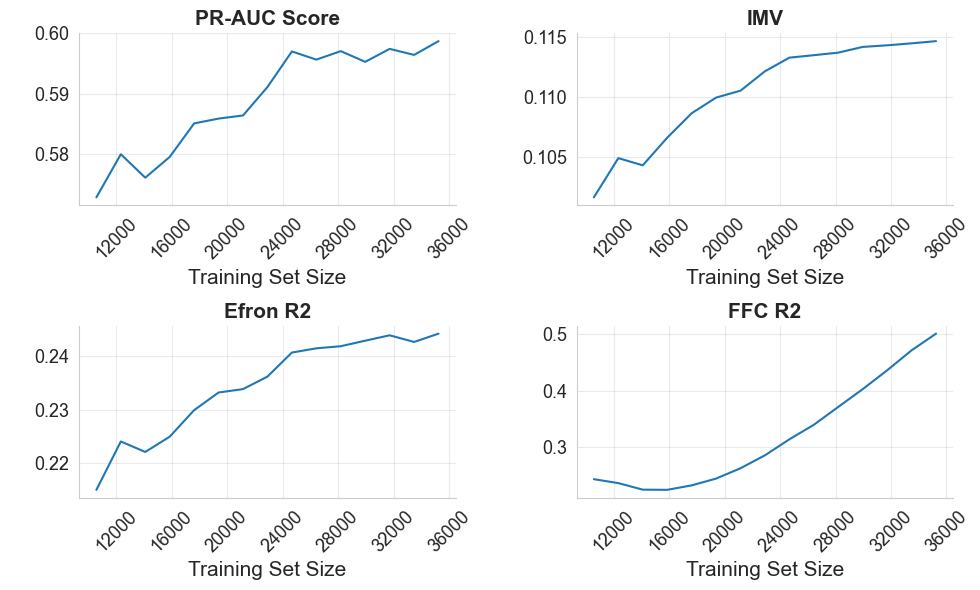

In [26]:
fig, axis = plt.subplots(2, 2)

fontsize_ticks = 13
fontsize_labels = 15
fig.subplots_adjust(left=0.08, bottom=0.08, top=0.95, right=0.99)
plt.rcParams['figure.figsize'] = [10, 6]

x_ticks = [22766, 28458, 34150, 39841, 45533, 51225, 56917]
count = 0
columns = ['test_pr_auc','test_imv_r2','test_efron_r2','test_ffc_r2']

ploted_col_dict = {'test_efron_r2': 'Efron R2',
                   'test_pr_auc': 'PR-AUC Score',
                   'test_ffc_r2': 'FFC R2',
                   'test_imv_r2': 'IMV'}


sns.set_style("whitegrid")
for (m, n), subplot in np.ndenumerate(axis):
    metric = columns[count]
    
    sns.lineplot(data=df_avf_on_size, x='train_subset_size',y=metric, ax=axis[m, n])

    axis[m, n].set_ylabel(' ',fontsize = fontsize_labels)
    axis[m, n].set_xlabel('Training Set Size',fontsize = fontsize_labels)
    axis[m, n].set_title(ploted_col_dict[metric],size=15,weight="bold")  # , size=fontsize_labels)

    # set ticks
    axis[m, n].tick_params(axis='x', rotation=45)

    
    axis[m, n].xaxis.set_major_locator(plt.MaxNLocator(8))

    axis[m, n].tick_params(axis='both', which='major', labelsize=fontsize_ticks)
    axis[m, n].spines['top'].set_visible(False)
    axis[m, n].spines['right'].set_visible(False)
    axis[m, n].grid(axis='both', alpha=0.4)
    axis[m, n].set_axisbelow(True)


    count += 1
fig.tight_layout()

plt.savefig(Path.cwd()/'graphs/model_outputs/asymptotics_sl_full_var.pdf')


In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.


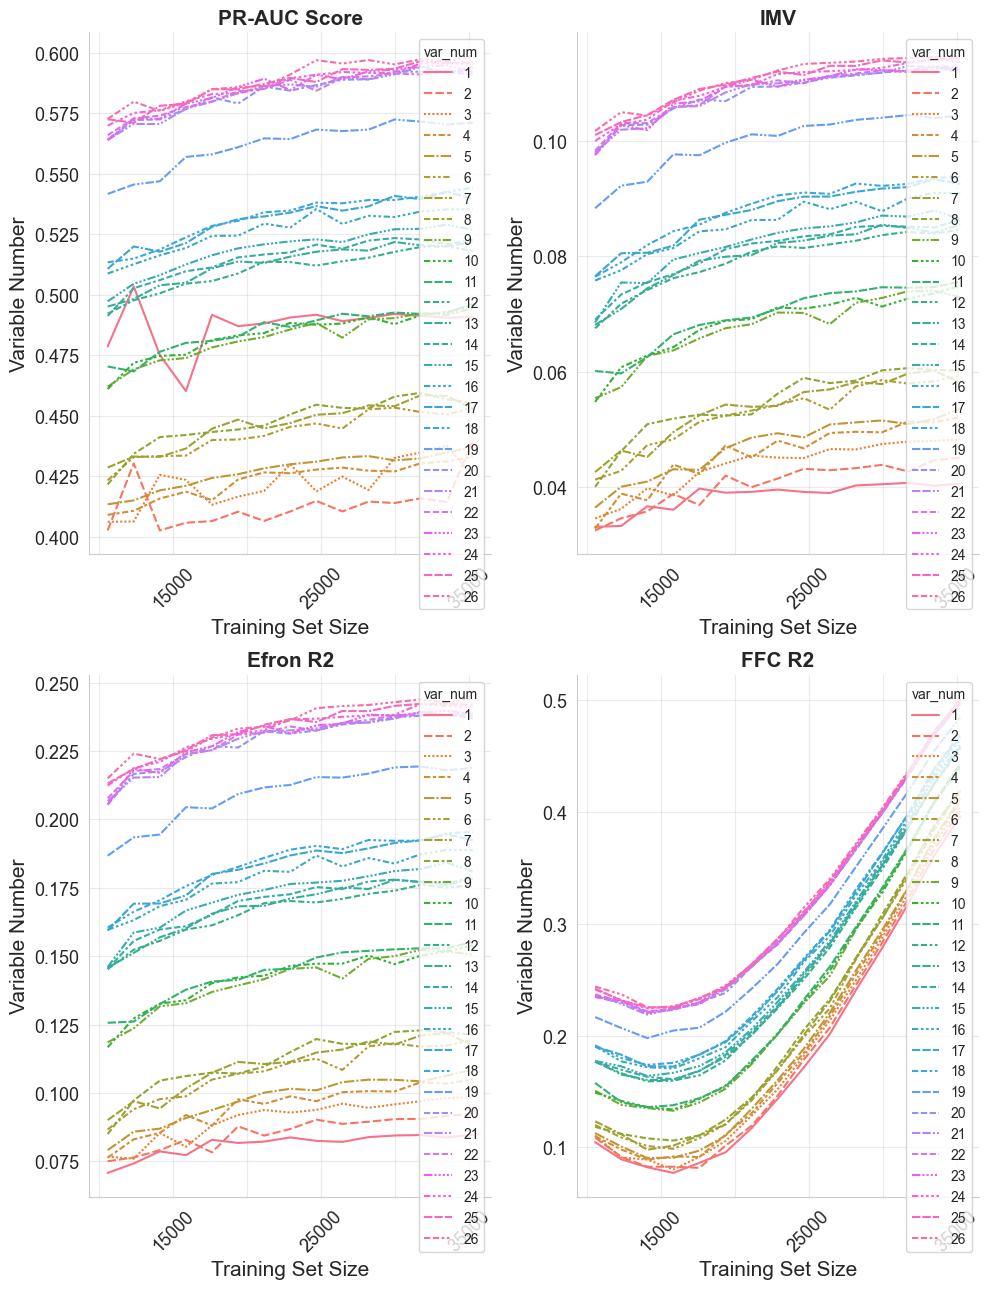

In [20]:



ploted_col_dict = {'test_efron_r2': 'Efron R2', 
                        'test_pr_auc': 'PR-AUC Score', 
                        'test_ffc_r2': 'FFC R2', 
                        'test_imv_r2': 'IMV'} 
      
      
fig, axis = plt.subplots(2, 2) 
fontsize_ticks = 13 
fontsize_labels = 15 
fig.subplots_adjust(left=0.08, bottom=0.08, top=0.95, right=0.99) 
plt.rcParams['figure.figsize'] = [10, 13] 

x_ticks = [22766, 28458, 34150, 39841, 45533, 51225, 56917] 
count = 0 
columns = ['test_pr_auc','test_imv_r2','test_efron_r2','test_ffc_r2'] 
for (m, n), subplot in np.ndenumerate(axis): 
    metric = columns[count] 
    pivot_table = df_avg.pivot('train_subset_size','var_num',  metric) 
    sns.lineplot(pivot_table, ax=axis[m, n]) 
    axis[m, n].set_ylabel('Variable Number',fontsize = fontsize_labels) 
    axis[m, n].set_xlabel('Training Set Size',fontsize = fontsize_labels) 
    axis[m, n].set_title(ploted_col_dict[metric],size=15,weight="bold" )  # , size=fontsize_labels) 

 # set ticks 

    axis[m, n].tick_params(axis='x', rotation=45) 

    every_nth = 2 
    for nth, label in enumerate(axis[m, n].xaxis.get_ticklabels()): 
        if nth % every_nth != 0: 
            label.set_visible(False) 

 # axis[m, n].xaxis.set_major_locator(plt.MaxNLocator(8)) 

    axis[m, n].tick_params(axis='both', which='major', labelsize=fontsize_ticks) 
    axis[m, n].spines['top'].set_visible(False) 
    axis[m, n].spines['right'].set_visible(False) 
    axis[m, n].grid(axis='both', alpha=0.4) 
    axis[m, n].set_axisbelow(True) 



    count += 1 
fig.tight_layout() 

plt.savefig(Path.cwd()/'graphs/model_outputs/asymptotics_sl_line_look.pdf')

## Figure 3: predictive asymptotics

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.


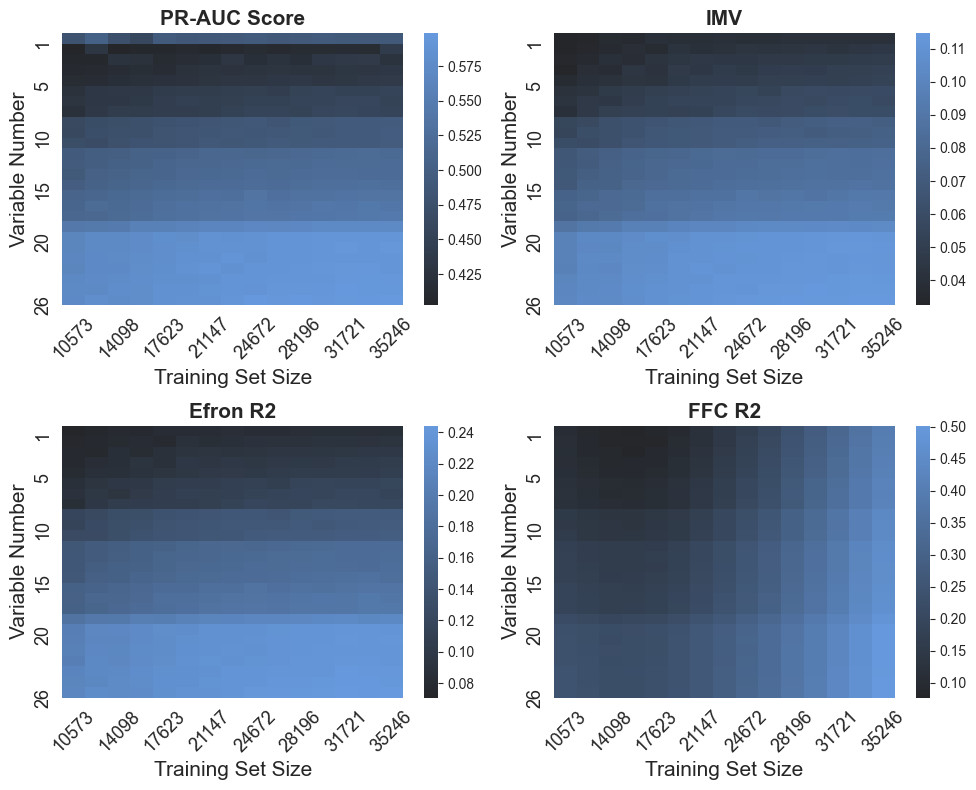

In [22]:

# plot
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

columns = []
for column in df.columns:
    if 'test' in column:
        columns.append(column)

df_to_plot = df_avg.drop_duplicates(subset=['train_subset_size', 'var_num']).copy()
df_to_plot.reset_index(inplace=True,drop=True)


columns.remove('test_f1_score')
columns.remove('test_pr_no_skill')
columns.remove('test_auc_score')
columns.remove('test_briern_r2')

ploted_col_dict = {'test_efron_r2': 'Efron R2',
                   'test_pr_auc': 'PR-AUC Score',
                   'test_ffc_r2': 'FFC R2',
                   'test_imv_r2': 'IMV'}


fig, axis = plt.subplots(2, 2)
fontsize_ticks = 13
fontsize_labels = 15
fig.subplots_adjust(left=0.08, bottom=0.08, top=0.95, right=0.99)
plt.rcParams['figure.figsize'] = [10, 13]

x_ticks = [22766, 28458, 34150, 39841, 45533, 51225, 56917]
count = 0
columns = ['test_pr_auc','test_imv_r2','test_efron_r2','test_ffc_r2']
for (m, n), subplot in np.ndenumerate(axis):
    metric = columns[count]
    pivot_table = df_to_plot.pivot('var_num', 'train_subset_size', metric)
    sns.heatmap(pivot_table, ax=axis[m, n], cmap=sns.dark_palette("#69d", reverse=False, as_cmap=True))

    axis[m, n].set_ylabel('Variable Number',fontsize = fontsize_labels)
    axis[m, n].set_xlabel('Training Set Size',fontsize = fontsize_labels)
    axis[m, n].set_title(ploted_col_dict[metric],size=15,weight="bold")  # , size=fontsize_labels)

    # set ticks
    axis[m, n].set_yticks([1, 5, 10, 15, 20, 26])
    axis[m, n].set_yticklabels([1, 5, 10, 15, 20, 26])
    axis[m, n].tick_params(axis='x', rotation=45)

    every_nth = 2
    for nth, label in enumerate(axis[m, n].xaxis.get_ticklabels()):
        if nth % every_nth != 0:
            label.set_visible(False)

    # axis[m, n].xaxis.set_major_locator(plt.MaxNLocator(8))

    axis[m, n].tick_params(axis='both', which='major', labelsize=fontsize_ticks)
    axis[m, n].spines['top'].set_visible(False)
    axis[m, n].spines['right'].set_visible(False)
    axis[m, n].grid(axis='both', alpha=0.4)
    axis[m, n].set_axisbelow(True)



    count += 1
fig.tight_layout()

plt.savefig(Path.cwd()/'graphs/model_outputs/asymptotics_sl.pdf')

# seed 

## Performance Plot

In [3]:
from src import seed 

In [ ]:
# perform the seed analysis and store the result in "Path.cwd()/'results/10000seed_comb_model_performance.csv'"
seed.seed_analysis()

In [ ]:

comb_type = 3
domain_name = 'combination_all'
df,model_params['domain_dict'][domain_name] = params.read_merged_data(type=comb_type)
model_params['var_dict']['dataset']='Datasource'

df_seed_selection_lst=pd.DataFrame(columns=['seed','model','imv','roc-auc','pr-auc','f1','efron_r2','ffc_r2','IP'])
df_seed_shap_performance_recorder = pd.DataFrame(columns = ['seed','model']+model_params['domain_dict'][domain_name])

count = 0
while count < 10000:
    seed = random.randint(1, 1000000000)
    model_selection = 'lgb'

    model_params['random_state'] = seed
    model = Models.Model_fixed_test_size(data=df, model_params=model_params, domain=domain_name, model='lgb', train_subset_size=1, order=0)

    evas = metric(model)

    temp = pd.DataFrame({'seed': seed, 'model': model_selection,
                         'imv': evas.imv, 'roc-auc': evas.auc_score,
                         'pr-auc': evas.pr_auc, 'f1': evas.pr_f1,
                         'efron_r2': evas.efron_rsquare, 'ffc_r2': evas.ffc_r2, 'IP': evas.pr_no_skill}, index=[0])
    df_seed_selection_lst.loc[len(df_seed_selection_lst),] = temp.loc[0,]

    # shap zone
    shap_values_test, shap_dict = Shap.shap_values_and_dict(model)

    # store the mean absolute shap value for each variable in a dictionary
    if len(shap_values_test.shape) == 3:
        shap_values_test.values = shap_values_test.values[:, :, 1]
    shap_dict = {}
    i = 0
    while i < shap_values_test.values.shape[1]:
        sum_shap = 0
        for m in shap_values_test.values[:, i]:
            sum_shap += np.abs(m)
        shap_dict[shap_values_test.feature_names[i]] = sum_shap / shap_values_test.values.shape[0]
        i += 1
    shap_dict['seed'] = seed
    shap_dict['model'] = model_selection
    temp_shap = pd.DataFrame(shap_dict, index=[0])
    df_seed_shap_performance_recorder.loc[len(df_seed_shap_performance_recorder),] = temp_shap.loc[0,]

    del model, evas
    # rest zone
    if count % 100 == 0:
        print(f'now seed is {seed} and we take 10s rest')
        print(f'\n{model_selection} and seed is {seed}, count={count}')
        df_seed_selection_lst.to_csv(Path.cwd() / f'results/10000seed_comb_model_performance_comb_{comb_type}.csv', index=False)
        df_seed_shap_performance_recorder.to_csv(Path.cwd() / f'results/10000seed_comb_shap_values_comb_{comb_type}.csv', index=False)

        time.sleep(10)
    count += 1

df_seed_selection_lst.to_csv(Path.cwd() / f'results/10000seed_comb_model_performance_comb_{comb_type}.csv', index=False)
df_seed_shap_performance_recorder.to_csv(Path.cwd() / f'results/10000seed_comb_shap_values_comb_{comb_type}.csv', index=False)


## Figure 4: Seed 

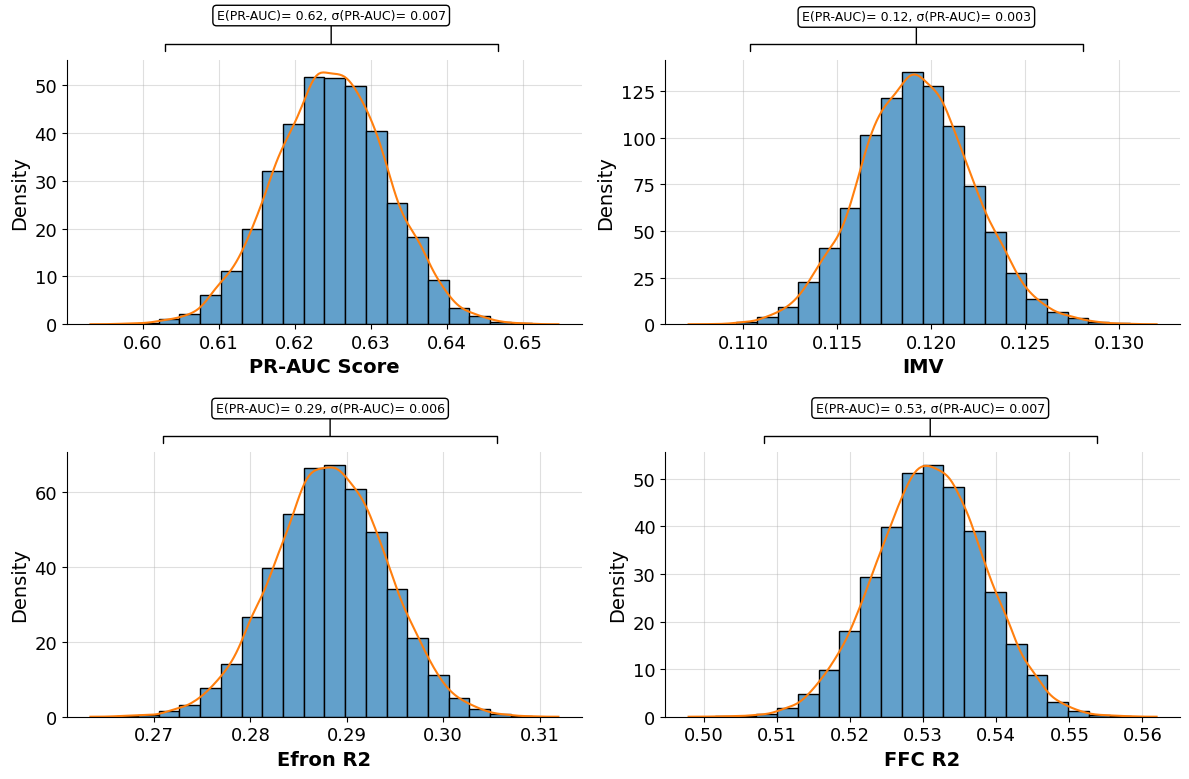

In [32]:
import time
import random
from src import params
import pandas as pd
from src import Models
from pathlib import Path
from src.Evaluate import metric
from src import Shap
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings('ignore')


def draw_brace(ax, mean, y, text):
    brace_width = 0.5
    text_pos_y = 1.08 * y + brace_width

    # Horizontal part (curly brace)
    ax.annotate('', xy=(mean, y), xycoords='data',
                xytext=(mean, text_pos_y), textcoords='data',
                arrowprops=dict(arrowstyle=f']-[, widthB=12, lengthB=0.5,angleB=0,widthA=0,lengthA=0', ),
                annotation_clip=False)

    # Text with expectation and variance
    ax.text(mean, text_pos_y, text, ha='center', va='bottom', fontsize=9,
            bbox=dict(boxstyle='Round', fc='white'))

    
df_eval = df_seed_selection_lst
fig, ax = plt.subplots(2, 2)
plt.rcParams["figure.figsize"] = [12, 8]
count = 0
colums = ['pr-auc', 'imv', 'efron_r2', 'ffc_r2']
column_dict = {'roc-auc': 'ROC-AUC Score', 'pr-auc': 'PR-AUC Score', 'f1': 'F1', 'efron_r2': 'Efron R2', 'ffc_r2': 'FFC R2', 'imv': 'IMV'}
fig.subplots_adjust(left=0.09, top=0.98, bottom=0.06, right=0.95)

# colors = ['#001c54', '#E89818']

letter_fontsize = 15
label_fontsize = 13
for (m, n), subplot in np.ndenumerate(ax):
    
    sns.distplot(df_eval[colums[count]],
                 hist_kws={'facecolor': colors['blue'], 'edgecolor': 'k', 'alpha':1},
                 kde_kws={'color': colors['orange']}, ax=ax[m, n], bins=20)
    # ax[m,n].hist(df_eval[colums[count]],color=color_blue,alpha=0.75,bins=30,edgecolor='black')
    ax[m, n].set_xlabel(column_dict[colums[count]], fontsize=label_fontsize + 1, weight='bold')
    ax[m, n].set_ylabel('Density', fontsize=label_fontsize + 1)
    ax[m, n].set_axisbelow(True)
    ax[m, n].grid(alpha=0.4,zorder=0)
    ax[m, n].tick_params(axis='both', which='major', labelsize=label_fontsize)

    # annotation part

    stats_text = f"E(PR-AUC)= {df_eval[colums[count]].mean():.2f}, \u03C3(PR-AUC)= {df_eval[colums[count]].std():.3f}"

    draw_brace(ax[m, n],
               df_eval[colums[count]].mean(),
               ax[m, n].get_ylim()[1] * 1.05,
               stats_text)

    count += 1
    ax[m, n].spines['top'].set_visible(False)
    ax[m, n].spines['right'].set_visible(False)

fig.tight_layout()
# plt.show()

plt.savefig(Path.cwd() / 'graphs/model_outputs/seed_lgb_10000_seed_distributions.pdf')


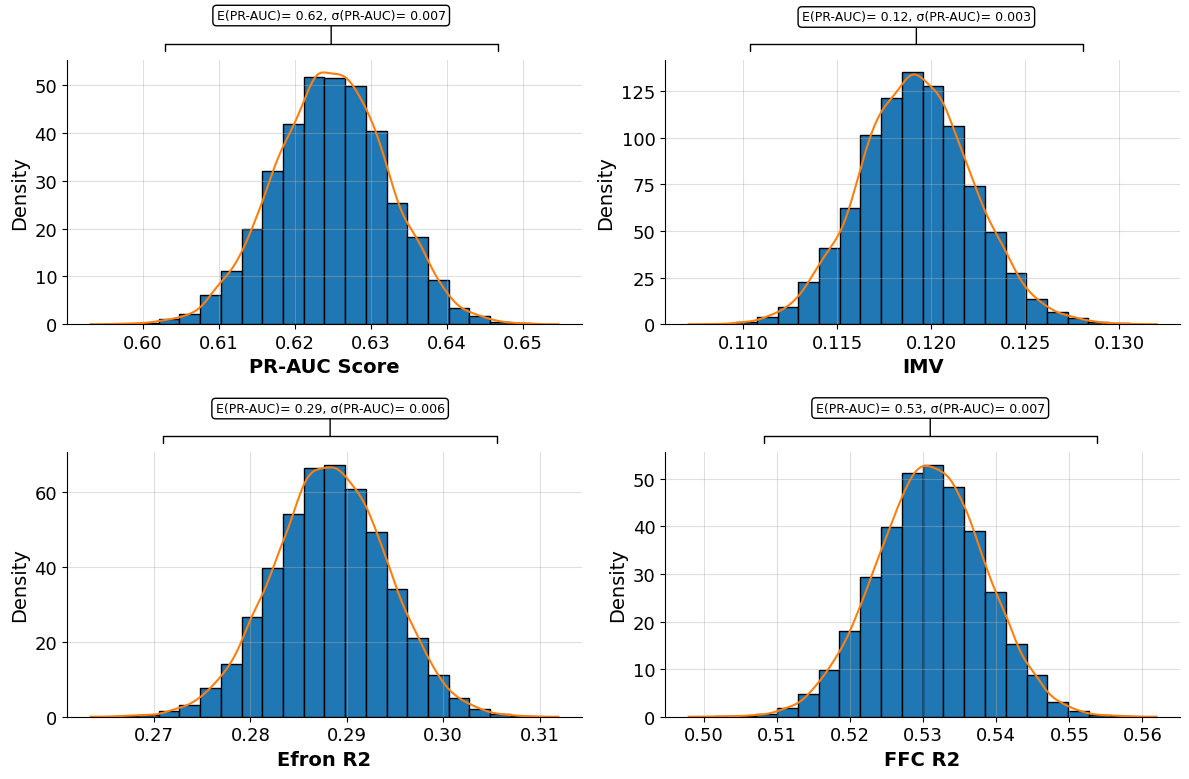

In [6]:
df_seed_selection_lst=pd.read_csv(Path.cwd()/'results/10000seed_comb_model_performance.csv')
seed.seed_plot(df_seed_selection_lst)

## Table 2 

In [297]:
df_table_2 = pd.DataFrame(columns=['metric','mean','min','max','standard deviation'])
for metric in ['pr-auc','imv','efron_r2','ffc_r2']:
    df_table_2.loc[len(df_table_2),]=[metric,
                                      df_seed_selection_lst[metric].mean(),
                                      df_seed_selection_lst[metric].min(), 
                                      df_seed_selection_lst[metric].max(), 
                                      df_seed_selection_lst[metric].std()]

In [305]:
# df_table_2 = pd.DataFrame(columns=['metric','mean','min','max','standard deviation'])
columns =list(df_seed_shap_performance_recorder.columns)
columns.remove('seed')
columns.remove('model')
              
for column in columns:
    if df_seed_shap_performance_recorder[column].mean()>=0.1:
        df_table_2.loc[len(df_table_2),]=[column,
                                          df_seed_shap_performance_recorder[column].mean(),
                                          df_seed_shap_performance_recorder[column].min(), 
                                          df_seed_shap_performance_recorder[column].max(), 
                                          df_seed_shap_performance_recorder[column].std()]


In [306]:
df_table_2

,metric,mean,min,max,standard deviation
0,pr-auc,0.624782,0.596617,0.651167,0.007409
1,imv,0.119216,0.108524,0.130572,0.002988
2,efron_r2,0.288267,0.266192,0.309161,0.00587
3,ffc_r2,0.530961,0.501446,0.558391,0.007451
4,currsmokeYN,0.140681,0.090471,0.186679,0.012491
5,age,0.964599,0.926125,1.004025,0.010889
6,modactivityYN,0.115472,0.070729,0.149918,0.01011
7,maleYN,0.229235,0.19567,0.27235,0.010056


In [313]:
replace_dic={'pr-auc':"PR-AUC",
 'imv':"IMV",
 'efron_r2':"Efron $R^2$",
 'ffc_r2':"FFC $R^2$",
 'currsmokeYN':'Current Smoker',
 'age':'Age',
 'modactivityYN':"Low/No Moderate Activity",
 'maleYN':'Male'}
for eva in df_table_2.metric:
    print("& {} & {} & {} & {} & {} \\\\".format(replace_dic[eva],
                                            round(df_table_2.loc[(df_table_2['metric']==eva),'mean'].values[0],3),
                                            round(df_table_2.loc[(df_table_2['metric']==eva),'min'].values[0],3),
                                            round(df_table_2.loc[(df_table_2['metric']==eva),'max'].values[0],3),
                                            round(df_table_2.loc[(df_table_2['metric']==eva),'standard deviation'].values[0],3)))

& PR-AUC & 0.625 & 0.597 & 0.651 & 0.007 \\
& IMV & 0.119 & 0.109 & 0.131 & 0.003 \\
& Efron $R^2$ & 0.288 & 0.266 & 0.309 & 0.006 \\
& FFC $R^2$ & 0.531 & 0.501 & 0.558 & 0.007 \\
& Current Smoker & 0.141 & 0.09 & 0.187 & 0.012 \\
& Age & 0.965 & 0.926 & 1.004 & 0.011 \\
& Low/No Moderate Activity & 0.115 & 0.071 & 0.15 & 0.01 \\
& Male & 0.229 & 0.196 & 0.272 & 0.01 \\


In [315]:
for eva in df_table_2.metric:
    print("{}".format(replace_dic[eva],round(df_table_2.loc[(df_table_2['metric']==eva),'max'].values[0]-df_table_2.loc[(df_table_2['metric']==eva),'min'].values[0],3)))
   

PR-AUC 0.055
IMV 0.022
Efron $R^2$ 0.043
FFC $R^2$ 0.057
Current Smoker 0.096
Age 0.078
Low/No Moderate Activity 0.079
Male 0.077
